In [114]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Conv2DTranspose
from keras.layers.activation import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [5]:
print(tf.__version__)

2.9.1


(28, 28)


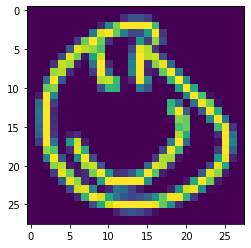

In [7]:
training_data = np.load('../datasets/full_numpy_bitmap_smiley face.npy')
# training_data = np.array([np.array_split(img_arr, 28) for img_arr in training_data])
training_data = training_data.reshape(training_data.shape[0], 28, 28).astype(
    "float32")
X_train = training_data
print(X_train[0].shape)
plt.imshow(X_train[0])

In [8]:
#Define input image dimensions
#Large images take too much time and resources.
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
print(img_shape)
noise_shape = (100,) #1D array of size 100 (latent vector / noise)
print(noise_shape)

(28, 28, 1)
(100,)


In [118]:
def build_generator():

    generator = Sequential()
    generator.add(Dense(256 * 7 * 7, input_shape=(100,)))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Reshape((7, 7, 256)))
    generator.add(Conv2DTranspose(128, kernel_size=5, strides=1, padding="same"))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Conv2DTranspose(64, kernel_size=3, strides=2,padding="same"))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation='tanh'))
    generator.summary()
    noise = Input(shape=(100,))
    fake_image = generator(noise)
    return Model(inputs=noise, outputs=fake_image)

def build_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(128, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding="same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.2))
    discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.2))
    discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.2))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.summary()
    img = Input(shape=(28, 28, 1))
    probability = discriminator(img)
    return Model(inputs=img, outputs=probability)

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("gen_images/epoch_%d.png" % epoch)
    plt.close()

def train(epochs, batch_size=128, save_interval=100):
    training_data = np.load('../datasets/full_numpy_bitmap_smiley face.npy')
    # training_data = np.array([np.array_split(img_arr, 28) for img_arr in training_data])
    training_data = training_data.reshape(training_data.shape[0], 28, 28)
    X_train = training_data
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3) 
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
        noise = np.random.normal(0, 1, (batch_size, 100)) 
        valid_y = np.array([1] * batch_size)
        g_loss = combined.train_on_batch(noise, valid_y)     
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        if epoch % save_interval == 0:
            save_imgs(epoch)


optimizer = Adam(0.001, 0.5)
disc_optimizer = RMSprop(0.005)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
z = Input(shape=(100,))
img = generator(z)     
discriminator.trainable = False  
valid = discriminator(img) 
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_191 (Conv2D)         (None, 14, 14, 128)       3328      
                                                                 
 leaky_re_lu_245 (LeakyReLU)  (None, 14, 14, 128)      0         
                                                                 
 dropout_94 (Dropout)        (None, 14, 14, 128)       0         
                                                                 
 conv2d_192 (Conv2D)         (None, 7, 7, 256)         295168    
                                                                 
 leaky_re_lu_246 (LeakyReLU)  (None, 7, 7, 256)        0         
                                                                 
 dropout_95 (Dropout)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_193 (Conv2D)         (None, 4, 4, 256)      

In [119]:
train(epochs=10000, batch_size=32, save_interval=50)

1/1 [==============================] - 0s 160ms/step
0 [D loss: 0.698400, acc.: 31.25%] [G loss: 0.640105]
1/1 [==============================] - 0s 36ms/step
1 [D loss: 0.462151, acc.: 50.00%] [G loss: 0.438325]
1/1 [==============================] - 0s 34ms/step
2 [D loss: 0.391764, acc.: 50.00%] [G loss: 0.414386]
1/1 [==============================] - 0s 32ms/step
3 [D loss: 0.367891, acc.: 53.12%] [G loss: 1.057422]
1/1 [==============================] - 0s 35ms/step
4 [D loss: 0.285294, acc.: 100.00%] [G loss: 2.034417]
1/1 [==============================] - 0s 42ms/step
5 [D loss: 0.283991, acc.: 100.00%] [G loss: 4.502493]
1/1 [==============================] - 0s 48ms/step
6 [D loss: 0.244045, acc.: 100.00%] [G loss: 4.980736]
1/1 [==============================] - 0s 37ms/step
7 [D loss: 0.040221, acc.: 100.00%] [G loss: 2.392835]
1/1 [==============================] - 0s 39ms/step
8 [D loss: 0.006066, acc.: 100.00%] [G loss: 0.369655]
1/1 [==============================] - 0

1/1 [==============================] - 0s 32ms/step
75 [D loss: 0.020240, acc.: 100.00%] [G loss: 0.059229]
1/1 [==============================] - 0s 33ms/step
76 [D loss: 0.037540, acc.: 100.00%] [G loss: 0.048419]
1/1 [==============================] - 0s 52ms/step
77 [D loss: 0.045714, acc.: 100.00%] [G loss: 0.062044]
1/1 [==============================] - 0s 47ms/step
78 [D loss: 0.011163, acc.: 100.00%] [G loss: 0.043557]
1/1 [==============================] - 0s 38ms/step
79 [D loss: 0.010059, acc.: 100.00%] [G loss: 0.040724]
1/1 [==============================] - 0s 32ms/step
80 [D loss: 0.031556, acc.: 100.00%] [G loss: 0.047070]
1/1 [==============================] - 0s 31ms/step
81 [D loss: 0.016001, acc.: 100.00%] [G loss: 0.046395]
1/1 [==============================] - 0s 37ms/step
82 [D loss: 0.022764, acc.: 100.00%] [G loss: 0.047935]
1/1 [==============================] - 0s 35ms/step
83 [D loss: 0.006606, acc.: 100.00%] [G loss: 0.037442]
1/1 [=======================

1/1 [==============================] - 0s 32ms/step
150 [D loss: 0.146791, acc.: 96.88%] [G loss: 3.427171]
1/1 [==============================] - 0s 35ms/step
151 [D loss: 0.256269, acc.: 87.50%] [G loss: 2.923284]
1/1 [==============================] - 0s 118ms/step
152 [D loss: 0.267583, acc.: 84.38%] [G loss: 3.777375]
1/1 [==============================] - 0s 42ms/step
153 [D loss: 0.114488, acc.: 96.88%] [G loss: 5.331351]
1/1 [==============================] - 0s 33ms/step
154 [D loss: 0.290439, acc.: 87.50%] [G loss: 3.231915]
1/1 [==============================] - 0s 37ms/step
155 [D loss: 0.187038, acc.: 93.75%] [G loss: 7.173763]
1/1 [==============================] - 0s 38ms/step
156 [D loss: 0.747903, acc.: 62.50%] [G loss: 4.070561]
1/1 [==============================] - 0s 36ms/step
157 [D loss: 0.060723, acc.: 100.00%] [G loss: 6.239606]
1/1 [==============================] - 0s 77ms/step
158 [D loss: 0.328063, acc.: 90.62%] [G loss: 7.157891]
1/1 [=====================

1/1 [==============================] - 0s 39ms/step
225 [D loss: 0.573175, acc.: 71.88%] [G loss: 1.232472]
1/1 [==============================] - 0s 34ms/step
226 [D loss: 1.038535, acc.: 59.38%] [G loss: 1.993593]
1/1 [==============================] - 0s 35ms/step
227 [D loss: 0.724850, acc.: 68.75%] [G loss: 1.187725]
1/1 [==============================] - 0s 40ms/step
228 [D loss: 0.672250, acc.: 68.75%] [G loss: 1.192362]
1/1 [==============================] - 0s 40ms/step
229 [D loss: 0.384218, acc.: 81.25%] [G loss: 1.807689]
1/1 [==============================] - 0s 35ms/step
230 [D loss: 0.305326, acc.: 84.38%] [G loss: 2.036207]
1/1 [==============================] - 0s 37ms/step
231 [D loss: 0.320351, acc.: 87.50%] [G loss: 1.919595]
1/1 [==============================] - 0s 43ms/step
232 [D loss: 0.576569, acc.: 71.88%] [G loss: 1.168125]
1/1 [==============================] - 0s 34ms/step
233 [D loss: 0.488097, acc.: 78.12%] [G loss: 1.295028]
1/1 [=======================

1/1 [==============================] - 0s 33ms/step
300 [D loss: 0.219876, acc.: 90.62%] [G loss: 1.473633]
1/1 [==============================] - 0s 37ms/step
301 [D loss: 0.249174, acc.: 87.50%] [G loss: 1.293546]
1/1 [==============================] - 0s 32ms/step
302 [D loss: 0.307114, acc.: 90.62%] [G loss: 1.519659]
1/1 [==============================] - 0s 35ms/step
303 [D loss: 0.415395, acc.: 81.25%] [G loss: 1.735912]
1/1 [==============================] - 0s 35ms/step
304 [D loss: 0.443876, acc.: 90.62%] [G loss: 1.119634]
1/1 [==============================] - 0s 33ms/step
305 [D loss: 0.338017, acc.: 90.62%] [G loss: 1.699263]
1/1 [==============================] - 0s 33ms/step
306 [D loss: 0.303904, acc.: 81.25%] [G loss: 1.275922]
1/1 [==============================] - 0s 36ms/step
307 [D loss: 0.706943, acc.: 68.75%] [G loss: 1.309048]
1/1 [==============================] - 0s 32ms/step
308 [D loss: 0.450330, acc.: 84.38%] [G loss: 1.557732]
1/1 [=======================

1/1 [==============================] - 0s 34ms/step
375 [D loss: 0.342083, acc.: 81.25%] [G loss: 2.101251]
1/1 [==============================] - 0s 34ms/step
376 [D loss: 0.508378, acc.: 78.12%] [G loss: 2.129395]
1/1 [==============================] - 0s 33ms/step
377 [D loss: 0.712285, acc.: 62.50%] [G loss: 1.792703]
1/1 [==============================] - 0s 33ms/step
378 [D loss: 0.524679, acc.: 75.00%] [G loss: 2.257900]
1/1 [==============================] - 0s 33ms/step
379 [D loss: 0.504606, acc.: 81.25%] [G loss: 1.965709]
1/1 [==============================] - 0s 38ms/step
380 [D loss: 0.520721, acc.: 75.00%] [G loss: 2.329502]
1/1 [==============================] - 0s 32ms/step
381 [D loss: 0.492912, acc.: 78.12%] [G loss: 2.355134]
1/1 [==============================] - 0s 33ms/step
382 [D loss: 0.467317, acc.: 84.38%] [G loss: 1.736678]
1/1 [==============================] - 0s 35ms/step
383 [D loss: 0.576271, acc.: 71.88%] [G loss: 2.167740]
1/1 [=======================

1/1 [==============================] - 0s 33ms/step
450 [D loss: 0.587669, acc.: 75.00%] [G loss: 1.819093]
1/1 [==============================] - 0s 33ms/step
451 [D loss: 0.441387, acc.: 78.12%] [G loss: 1.825417]
1/1 [==============================] - 0s 32ms/step
452 [D loss: 0.407630, acc.: 75.00%] [G loss: 1.783393]
1/1 [==============================] - 0s 37ms/step
453 [D loss: 0.709361, acc.: 50.00%] [G loss: 1.095621]
1/1 [==============================] - 0s 40ms/step
454 [D loss: 0.563040, acc.: 71.88%] [G loss: 1.497378]
1/1 [==============================] - 0s 32ms/step
455 [D loss: 0.701797, acc.: 59.38%] [G loss: 1.560296]
1/1 [==============================] - 0s 34ms/step
456 [D loss: 0.863033, acc.: 56.25%] [G loss: 1.601623]
1/1 [==============================] - 0s 33ms/step
457 [D loss: 0.367000, acc.: 84.38%] [G loss: 1.834409]
1/1 [==============================] - 0s 36ms/step
458 [D loss: 0.773343, acc.: 53.12%] [G loss: 1.698279]
1/1 [=======================

1/1 [==============================] - 0s 34ms/step
525 [D loss: 0.715525, acc.: 65.62%] [G loss: 1.446624]
1/1 [==============================] - 0s 32ms/step
526 [D loss: 0.261439, acc.: 100.00%] [G loss: 1.390721]
1/1 [==============================] - 0s 37ms/step
527 [D loss: 0.571740, acc.: 71.88%] [G loss: 1.439057]
1/1 [==============================] - 0s 34ms/step
528 [D loss: 0.429705, acc.: 78.12%] [G loss: 1.741610]
1/1 [==============================] - 0s 32ms/step
529 [D loss: 0.681903, acc.: 68.75%] [G loss: 1.220168]
1/1 [==============================] - 0s 32ms/step
530 [D loss: 0.506901, acc.: 71.88%] [G loss: 1.848104]
1/1 [==============================] - 0s 34ms/step
531 [D loss: 0.458874, acc.: 81.25%] [G loss: 2.212537]
1/1 [==============================] - 0s 35ms/step
532 [D loss: 0.987192, acc.: 56.25%] [G loss: 1.553687]
1/1 [==============================] - 0s 33ms/step
533 [D loss: 0.496982, acc.: 68.75%] [G loss: 1.758101]
1/1 [======================

1/1 [==============================] - 0s 37ms/step
600 [D loss: 0.590455, acc.: 78.12%] [G loss: 1.621448]
1/1 [==============================] - 0s 34ms/step
601 [D loss: 0.546102, acc.: 75.00%] [G loss: 1.761995]
1/1 [==============================] - 0s 31ms/step
602 [D loss: 0.653165, acc.: 65.62%] [G loss: 1.437656]
1/1 [==============================] - 0s 32ms/step
603 [D loss: 0.497295, acc.: 84.38%] [G loss: 1.317695]
1/1 [==============================] - 0s 34ms/step
604 [D loss: 0.494026, acc.: 84.38%] [G loss: 1.646077]
1/1 [==============================] - 0s 43ms/step
605 [D loss: 0.718848, acc.: 56.25%] [G loss: 1.337260]
1/1 [==============================] - 0s 35ms/step
606 [D loss: 0.564332, acc.: 65.62%] [G loss: 1.518860]
1/1 [==============================] - 0s 34ms/step
607 [D loss: 0.588385, acc.: 75.00%] [G loss: 1.431765]
1/1 [==============================] - 0s 34ms/step
608 [D loss: 0.446303, acc.: 71.88%] [G loss: 1.741535]
1/1 [=======================

1/1 [==============================] - 0s 35ms/step
675 [D loss: 0.543578, acc.: 81.25%] [G loss: 1.301285]
1/1 [==============================] - 0s 35ms/step
676 [D loss: 0.561860, acc.: 68.75%] [G loss: 1.777125]
1/1 [==============================] - 0s 33ms/step
677 [D loss: 0.507946, acc.: 71.88%] [G loss: 1.806064]
1/1 [==============================] - 0s 34ms/step
678 [D loss: 0.647965, acc.: 71.88%] [G loss: 1.331556]
1/1 [==============================] - 0s 34ms/step
679 [D loss: 0.522246, acc.: 68.75%] [G loss: 1.707863]
1/1 [==============================] - 0s 32ms/step
680 [D loss: 0.497965, acc.: 81.25%] [G loss: 1.710238]
1/1 [==============================] - 0s 34ms/step
681 [D loss: 0.366064, acc.: 78.12%] [G loss: 1.680426]
1/1 [==============================] - 0s 39ms/step
682 [D loss: 0.533762, acc.: 68.75%] [G loss: 1.666331]
1/1 [==============================] - 0s 32ms/step
683 [D loss: 0.586145, acc.: 75.00%] [G loss: 1.976258]
1/1 [=======================

1/1 [==============================] - 0s 32ms/step
750 [D loss: 0.713603, acc.: 56.25%] [G loss: 1.477091]
1/1 [==============================] - 0s 39ms/step
751 [D loss: 0.644255, acc.: 68.75%] [G loss: 1.486041]
1/1 [==============================] - 0s 42ms/step
752 [D loss: 0.693644, acc.: 65.62%] [G loss: 1.495701]
1/1 [==============================] - 0s 36ms/step
753 [D loss: 0.627765, acc.: 62.50%] [G loss: 2.264201]
1/1 [==============================] - 0s 60ms/step
754 [D loss: 0.597493, acc.: 81.25%] [G loss: 1.354270]
1/1 [==============================] - 0s 61ms/step
755 [D loss: 0.540063, acc.: 71.88%] [G loss: 1.430713]
1/1 [==============================] - 0s 37ms/step
756 [D loss: 0.728627, acc.: 50.00%] [G loss: 1.297567]
1/1 [==============================] - 0s 42ms/step
757 [D loss: 0.558128, acc.: 71.88%] [G loss: 1.656408]
1/1 [==============================] - 0s 38ms/step
758 [D loss: 0.591768, acc.: 65.62%] [G loss: 1.518384]
1/1 [=======================

1/1 [==============================] - 0s 39ms/step
825 [D loss: 0.371482, acc.: 87.50%] [G loss: 1.687273]
1/1 [==============================] - 0s 36ms/step
826 [D loss: 0.687006, acc.: 68.75%] [G loss: 1.344210]
1/1 [==============================] - 0s 36ms/step
827 [D loss: 0.400165, acc.: 87.50%] [G loss: 1.852511]
1/1 [==============================] - 0s 40ms/step
828 [D loss: 0.390063, acc.: 84.38%] [G loss: 1.912232]
1/1 [==============================] - 0s 37ms/step
829 [D loss: 0.807627, acc.: 59.38%] [G loss: 1.379206]
1/1 [==============================] - 0s 36ms/step
830 [D loss: 0.566566, acc.: 78.12%] [G loss: 1.613310]
1/1 [==============================] - 0s 38ms/step
831 [D loss: 0.673995, acc.: 59.38%] [G loss: 1.922190]
1/1 [==============================] - 0s 38ms/step
832 [D loss: 0.630071, acc.: 65.62%] [G loss: 1.576666]
1/1 [==============================] - 0s 37ms/step
833 [D loss: 0.562245, acc.: 59.38%] [G loss: 1.261592]
1/1 [=======================

1/1 [==============================] - 0s 39ms/step
900 [D loss: 0.629277, acc.: 71.88%] [G loss: 2.139599]
1/1 [==============================] - 0s 38ms/step
901 [D loss: 0.750098, acc.: 56.25%] [G loss: 1.572625]
1/1 [==============================] - 0s 39ms/step
902 [D loss: 0.465636, acc.: 78.12%] [G loss: 1.582049]
1/1 [==============================] - 0s 39ms/step
903 [D loss: 0.883236, acc.: 59.38%] [G loss: 1.632612]
1/1 [==============================] - 0s 73ms/step
904 [D loss: 0.581079, acc.: 62.50%] [G loss: 2.434363]
1/1 [==============================] - 0s 49ms/step
905 [D loss: 0.620094, acc.: 68.75%] [G loss: 1.554101]
1/1 [==============================] - 0s 36ms/step
906 [D loss: 0.482452, acc.: 68.75%] [G loss: 2.093030]
1/1 [==============================] - 0s 39ms/step
907 [D loss: 0.813140, acc.: 53.12%] [G loss: 1.809096]
1/1 [==============================] - 0s 37ms/step
908 [D loss: 0.600998, acc.: 65.62%] [G loss: 1.541202]
1/1 [=======================

1/1 [==============================] - 0s 40ms/step
975 [D loss: 0.625277, acc.: 62.50%] [G loss: 1.444143]
1/1 [==============================] - 0s 37ms/step
976 [D loss: 0.558807, acc.: 68.75%] [G loss: 1.723433]
1/1 [==============================] - 0s 40ms/step
977 [D loss: 0.460965, acc.: 75.00%] [G loss: 1.395602]
1/1 [==============================] - 0s 41ms/step
978 [D loss: 0.666251, acc.: 65.62%] [G loss: 1.590667]
1/1 [==============================] - 0s 37ms/step
979 [D loss: 0.376906, acc.: 90.62%] [G loss: 1.906870]
1/1 [==============================] - 0s 39ms/step
980 [D loss: 0.572986, acc.: 75.00%] [G loss: 1.401037]
1/1 [==============================] - 0s 36ms/step
981 [D loss: 0.536866, acc.: 75.00%] [G loss: 1.522778]
1/1 [==============================] - 0s 36ms/step
982 [D loss: 0.527868, acc.: 75.00%] [G loss: 1.866267]
1/1 [==============================] - 0s 38ms/step
983 [D loss: 0.668742, acc.: 62.50%] [G loss: 1.676310]
1/1 [=======================

1/1 [==============================] - 0s 38ms/step
1050 [D loss: 0.742169, acc.: 65.62%] [G loss: 2.413926]
1/1 [==============================] - 0s 38ms/step
1051 [D loss: 0.539683, acc.: 68.75%] [G loss: 2.246565]
1/1 [==============================] - 0s 38ms/step
1052 [D loss: 0.516554, acc.: 78.12%] [G loss: 1.782723]
1/1 [==============================] - 0s 36ms/step
1053 [D loss: 0.693488, acc.: 71.88%] [G loss: 2.313891]
1/1 [==============================] - 0s 38ms/step
1054 [D loss: 0.565807, acc.: 68.75%] [G loss: 2.491087]
1/1 [==============================] - 0s 49ms/step
1055 [D loss: 0.820004, acc.: 62.50%] [G loss: 1.647093]
1/1 [==============================] - 0s 49ms/step
1056 [D loss: 0.490098, acc.: 75.00%] [G loss: 1.397895]
1/1 [==============================] - 0s 44ms/step
1057 [D loss: 0.625230, acc.: 65.62%] [G loss: 1.778894]
1/1 [==============================] - 0s 52ms/step
1058 [D loss: 0.557766, acc.: 68.75%] [G loss: 2.271851]
1/1 [==============

1/1 [==============================] - 0s 37ms/step
1124 [D loss: 0.348130, acc.: 87.50%] [G loss: 2.187566]
1/1 [==============================] - 0s 35ms/step
1125 [D loss: 0.453014, acc.: 78.12%] [G loss: 1.579812]
1/1 [==============================] - 0s 40ms/step
1126 [D loss: 0.521017, acc.: 81.25%] [G loss: 2.402389]
1/1 [==============================] - 0s 37ms/step
1127 [D loss: 0.560494, acc.: 65.62%] [G loss: 1.928538]
1/1 [==============================] - 0s 37ms/step
1128 [D loss: 0.372439, acc.: 84.38%] [G loss: 2.017062]
1/1 [==============================] - 0s 40ms/step
1129 [D loss: 0.341273, acc.: 84.38%] [G loss: 2.057745]
1/1 [==============================] - 0s 34ms/step
1130 [D loss: 0.369961, acc.: 81.25%] [G loss: 1.748512]
1/1 [==============================] - 0s 38ms/step
1131 [D loss: 0.518633, acc.: 78.12%] [G loss: 2.523076]
1/1 [==============================] - 0s 36ms/step
1132 [D loss: 0.468776, acc.: 78.12%] [G loss: 2.176573]
1/1 [==============

1/1 [==============================] - 0s 39ms/step
1199 [D loss: 0.483612, acc.: 75.00%] [G loss: 1.569315]
1/1 [==============================] - 0s 38ms/step
1200 [D loss: 0.562595, acc.: 65.62%] [G loss: 1.362345]
1/1 [==============================] - 0s 38ms/step
1201 [D loss: 0.237408, acc.: 96.88%] [G loss: 2.659766]
1/1 [==============================] - 0s 36ms/step
1202 [D loss: 0.553693, acc.: 71.88%] [G loss: 1.889242]
1/1 [==============================] - 0s 35ms/step
1203 [D loss: 0.836040, acc.: 46.88%] [G loss: 2.098125]
1/1 [==============================] - 0s 61ms/step
1204 [D loss: 0.410483, acc.: 84.38%] [G loss: 1.903940]
1/1 [==============================] - 0s 43ms/step
1205 [D loss: 0.644901, acc.: 68.75%] [G loss: 1.726008]
1/1 [==============================] - 0s 36ms/step
1206 [D loss: 0.466715, acc.: 81.25%] [G loss: 2.837039]
1/1 [==============================] - 0s 38ms/step
1207 [D loss: 0.464247, acc.: 81.25%] [G loss: 2.415162]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
1273 [D loss: 0.312500, acc.: 84.38%] [G loss: 3.085941]
1/1 [==============================] - 0s 35ms/step
1274 [D loss: 0.687497, acc.: 56.25%] [G loss: 2.518891]
1/1 [==============================] - 0s 37ms/step
1275 [D loss: 0.531604, acc.: 62.50%] [G loss: 2.407454]
1/1 [==============================] - 0s 36ms/step
1276 [D loss: 0.391451, acc.: 84.38%] [G loss: 2.152095]
1/1 [==============================] - 0s 35ms/step
1277 [D loss: 0.377042, acc.: 87.50%] [G loss: 1.819941]
1/1 [==============================] - 0s 38ms/step
1278 [D loss: 0.430306, acc.: 78.12%] [G loss: 1.957866]
1/1 [==============================] - 0s 35ms/step
1279 [D loss: 0.536723, acc.: 75.00%] [G loss: 2.173752]
1/1 [==============================] - 0s 34ms/step
1280 [D loss: 0.239003, acc.: 96.88%] [G loss: 2.820683]
1/1 [==============================] - 0s 37ms/step
1281 [D loss: 0.624192, acc.: 75.00%] [G loss: 1.613804]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
1348 [D loss: 0.642984, acc.: 53.12%] [G loss: 3.006065]
1/1 [==============================] - 0s 37ms/step
1349 [D loss: 0.251114, acc.: 93.75%] [G loss: 2.691326]
1/1 [==============================] - 0s 36ms/step
1350 [D loss: 0.880128, acc.: 53.12%] [G loss: 2.160518]
1/1 [==============================] - 0s 40ms/step
1351 [D loss: 0.356576, acc.: 81.25%] [G loss: 2.796030]
1/1 [==============================] - 0s 35ms/step
1352 [D loss: 0.627095, acc.: 62.50%] [G loss: 2.203587]
1/1 [==============================] - 0s 40ms/step
1353 [D loss: 0.331357, acc.: 84.38%] [G loss: 2.837824]
1/1 [==============================] - 0s 67ms/step
1354 [D loss: 0.290778, acc.: 93.75%] [G loss: 3.486793]
1/1 [==============================] - 0s 45ms/step
1355 [D loss: 0.800057, acc.: 75.00%] [G loss: 2.095037]
1/1 [==============================] - 0s 44ms/step
1356 [D loss: 0.294412, acc.: 90.62%] [G loss: 2.525558]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
1422 [D loss: 0.423884, acc.: 87.50%] [G loss: 2.961751]
1/1 [==============================] - 0s 36ms/step
1423 [D loss: 0.653555, acc.: 71.88%] [G loss: 3.409973]
1/1 [==============================] - 0s 36ms/step
1424 [D loss: 0.344623, acc.: 84.38%] [G loss: 3.574716]
1/1 [==============================] - 0s 34ms/step
1425 [D loss: 0.592620, acc.: 81.25%] [G loss: 2.642248]
1/1 [==============================] - 0s 36ms/step
1426 [D loss: 0.248259, acc.: 90.62%] [G loss: 2.902168]
1/1 [==============================] - 0s 37ms/step
1427 [D loss: 0.307855, acc.: 87.50%] [G loss: 2.751285]
1/1 [==============================] - 0s 34ms/step
1428 [D loss: 0.366973, acc.: 81.25%] [G loss: 2.935683]
1/1 [==============================] - 0s 36ms/step
1429 [D loss: 0.318583, acc.: 87.50%] [G loss: 2.487021]
1/1 [==============================] - 0s 38ms/step
1430 [D loss: 0.570859, acc.: 75.00%] [G loss: 3.548990]
1/1 [==============

1/1 [==============================] - 0s 33ms/step
1497 [D loss: 0.579913, acc.: 84.38%] [G loss: 3.063120]
1/1 [==============================] - 0s 44ms/step
1498 [D loss: 0.392447, acc.: 84.38%] [G loss: 2.780971]
1/1 [==============================] - 0s 36ms/step
1499 [D loss: 0.276968, acc.: 87.50%] [G loss: 2.596037]
1/1 [==============================] - 0s 34ms/step
1500 [D loss: 0.728128, acc.: 62.50%] [G loss: 2.809320]
1/1 [==============================] - 0s 37ms/step
1501 [D loss: 0.510107, acc.: 71.88%] [G loss: 2.616753]
1/1 [==============================] - 0s 35ms/step
1502 [D loss: 0.479762, acc.: 75.00%] [G loss: 3.168608]
1/1 [==============================] - 0s 37ms/step
1503 [D loss: 0.195593, acc.: 96.88%] [G loss: 2.523118]
1/1 [==============================] - 0s 60ms/step
1504 [D loss: 0.190242, acc.: 90.62%] [G loss: 2.955246]
1/1 [==============================] - 0s 46ms/step
1505 [D loss: 0.739249, acc.: 65.62%] [G loss: 2.237283]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
1571 [D loss: 0.333704, acc.: 84.38%] [G loss: 2.484713]
1/1 [==============================] - 0s 34ms/step
1572 [D loss: 0.296979, acc.: 90.62%] [G loss: 3.008262]
1/1 [==============================] - 0s 34ms/step
1573 [D loss: 0.435523, acc.: 81.25%] [G loss: 2.268481]
1/1 [==============================] - 0s 37ms/step
1574 [D loss: 0.207550, acc.: 90.62%] [G loss: 2.943928]
1/1 [==============================] - 0s 40ms/step
1575 [D loss: 0.661876, acc.: 65.62%] [G loss: 3.250248]
1/1 [==============================] - 0s 35ms/step
1576 [D loss: 0.686993, acc.: 71.88%] [G loss: 3.195601]
1/1 [==============================] - 0s 34ms/step
1577 [D loss: 0.276727, acc.: 90.62%] [G loss: 2.604868]
1/1 [==============================] - 0s 38ms/step
1578 [D loss: 0.281273, acc.: 87.50%] [G loss: 2.653293]
1/1 [==============================] - 0s 37ms/step
1579 [D loss: 0.487981, acc.: 75.00%] [G loss: 3.071281]
1/1 [==============

1/1 [==============================] - 0s 38ms/step
1646 [D loss: 0.488922, acc.: 75.00%] [G loss: 2.029330]
1/1 [==============================] - 0s 35ms/step
1647 [D loss: 0.477693, acc.: 78.12%] [G loss: 2.004842]
1/1 [==============================] - 0s 37ms/step
1648 [D loss: 0.441541, acc.: 78.12%] [G loss: 2.109802]
1/1 [==============================] - 0s 38ms/step
1649 [D loss: 0.476500, acc.: 81.25%] [G loss: 1.436622]
1/1 [==============================] - 0s 35ms/step
1650 [D loss: 0.404359, acc.: 81.25%] [G loss: 1.594131]
1/1 [==============================] - 0s 37ms/step
1651 [D loss: 0.756495, acc.: 53.12%] [G loss: 2.485080]
1/1 [==============================] - 0s 36ms/step
1652 [D loss: 0.736032, acc.: 59.38%] [G loss: 1.652841]
1/1 [==============================] - 0s 35ms/step
1653 [D loss: 0.606352, acc.: 62.50%] [G loss: 1.686940]
1/1 [==============================] - 0s 65ms/step
1654 [D loss: 0.346266, acc.: 90.62%] [G loss: 1.971630]
1/1 [==============

1/1 [==============================] - 0s 39ms/step
1720 [D loss: 0.278928, acc.: 87.50%] [G loss: 3.317201]
1/1 [==============================] - 0s 37ms/step
1721 [D loss: 0.430704, acc.: 78.12%] [G loss: 2.234361]
1/1 [==============================] - 0s 36ms/step
1722 [D loss: 0.712273, acc.: 59.38%] [G loss: 2.381890]
1/1 [==============================] - 0s 35ms/step
1723 [D loss: 0.323776, acc.: 81.25%] [G loss: 2.599817]
1/1 [==============================] - 0s 34ms/step
1724 [D loss: 0.319431, acc.: 87.50%] [G loss: 2.306228]
1/1 [==============================] - 0s 40ms/step
1725 [D loss: 0.393652, acc.: 90.62%] [G loss: 2.278684]
1/1 [==============================] - 0s 36ms/step
1726 [D loss: 0.307420, acc.: 90.62%] [G loss: 2.108564]
1/1 [==============================] - 0s 35ms/step
1727 [D loss: 0.401566, acc.: 84.38%] [G loss: 2.316728]
1/1 [==============================] - 0s 38ms/step
1728 [D loss: 0.474118, acc.: 78.12%] [G loss: 2.064030]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
1795 [D loss: 0.512877, acc.: 75.00%] [G loss: 1.995589]
1/1 [==============================] - 0s 36ms/step
1796 [D loss: 0.396282, acc.: 78.12%] [G loss: 2.323112]
1/1 [==============================] - 0s 35ms/step
1797 [D loss: 0.181001, acc.: 90.62%] [G loss: 2.537153]
1/1 [==============================] - 0s 34ms/step
1798 [D loss: 0.285993, acc.: 84.38%] [G loss: 2.280283]
1/1 [==============================] - 0s 38ms/step
1799 [D loss: 0.466020, acc.: 81.25%] [G loss: 2.538164]
1/1 [==============================] - 0s 36ms/step
1800 [D loss: 0.333265, acc.: 90.62%] [G loss: 2.400307]
1/1 [==============================] - 0s 38ms/step
1801 [D loss: 0.471677, acc.: 71.88%] [G loss: 2.236333]
1/1 [==============================] - 0s 35ms/step
1802 [D loss: 0.505712, acc.: 78.12%] [G loss: 2.485201]
1/1 [==============================] - 0s 35ms/step
1803 [D loss: 0.418189, acc.: 84.38%] [G loss: 2.399748]
1/1 [==============

1/1 [==============================] - 0s 40ms/step
1869 [D loss: 0.284650, acc.: 87.50%] [G loss: 2.635561]
1/1 [==============================] - 0s 39ms/step
1870 [D loss: 0.332548, acc.: 81.25%] [G loss: 2.805603]
1/1 [==============================] - 0s 34ms/step
1871 [D loss: 0.271058, acc.: 96.88%] [G loss: 2.401175]
1/1 [==============================] - 0s 34ms/step
1872 [D loss: 0.285614, acc.: 87.50%] [G loss: 3.098383]
1/1 [==============================] - 0s 35ms/step
1873 [D loss: 0.197655, acc.: 90.62%] [G loss: 3.556413]
1/1 [==============================] - 0s 35ms/step
1874 [D loss: 0.499745, acc.: 75.00%] [G loss: 1.966890]
1/1 [==============================] - 0s 34ms/step
1875 [D loss: 0.236590, acc.: 90.62%] [G loss: 3.051789]
1/1 [==============================] - 0s 35ms/step
1876 [D loss: 0.157126, acc.: 100.00%] [G loss: 2.895674]
1/1 [==============================] - 0s 34ms/step
1877 [D loss: 0.457258, acc.: 87.50%] [G loss: 2.800841]
1/1 [=============

1/1 [==============================] - 0s 37ms/step
1944 [D loss: 0.248034, acc.: 93.75%] [G loss: 3.410357]
1/1 [==============================] - 0s 36ms/step
1945 [D loss: 0.228300, acc.: 93.75%] [G loss: 3.200153]
1/1 [==============================] - 0s 34ms/step
1946 [D loss: 0.268514, acc.: 87.50%] [G loss: 2.404828]
1/1 [==============================] - 0s 34ms/step
1947 [D loss: 0.180384, acc.: 96.88%] [G loss: 2.934447]
1/1 [==============================] - 0s 39ms/step
1948 [D loss: 0.388982, acc.: 84.38%] [G loss: 2.756028]
1/1 [==============================] - 0s 34ms/step
1949 [D loss: 0.571380, acc.: 75.00%] [G loss: 2.470032]
1/1 [==============================] - 0s 36ms/step
1950 [D loss: 0.237850, acc.: 90.62%] [G loss: 3.130381]
1/1 [==============================] - 0s 41ms/step
1951 [D loss: 0.170302, acc.: 93.75%] [G loss: 1.969906]
1/1 [==============================] - 0s 40ms/step
1952 [D loss: 0.271527, acc.: 90.62%] [G loss: 2.813116]
1/1 [==============

1/1 [==============================] - 0s 41ms/step
2018 [D loss: 0.407262, acc.: 81.25%] [G loss: 2.795329]
1/1 [==============================] - 0s 36ms/step
2019 [D loss: 0.155874, acc.: 100.00%] [G loss: 3.367280]
1/1 [==============================] - 0s 36ms/step
2020 [D loss: 0.279348, acc.: 87.50%] [G loss: 3.521842]
1/1 [==============================] - 0s 36ms/step
2021 [D loss: 0.446443, acc.: 81.25%] [G loss: 3.194961]
1/1 [==============================] - 0s 36ms/step
2022 [D loss: 0.408510, acc.: 71.88%] [G loss: 3.358959]
1/1 [==============================] - 0s 40ms/step
2023 [D loss: 0.246553, acc.: 87.50%] [G loss: 3.086063]
1/1 [==============================] - 0s 35ms/step
2024 [D loss: 0.202290, acc.: 93.75%] [G loss: 3.226969]
1/1 [==============================] - 0s 35ms/step
2025 [D loss: 0.128553, acc.: 96.88%] [G loss: 3.517465]
1/1 [==============================] - 0s 38ms/step
2026 [D loss: 0.506001, acc.: 71.88%] [G loss: 3.199580]
1/1 [=============

1/1 [==============================] - 0s 38ms/step
2093 [D loss: 0.188317, acc.: 93.75%] [G loss: 3.189284]
1/1 [==============================] - 0s 37ms/step
2094 [D loss: 0.056874, acc.: 100.00%] [G loss: 3.728592]
1/1 [==============================] - 0s 36ms/step
2095 [D loss: 0.310982, acc.: 84.38%] [G loss: 3.302196]
1/1 [==============================] - 0s 34ms/step
2096 [D loss: 0.294851, acc.: 84.38%] [G loss: 4.660785]
1/1 [==============================] - 0s 36ms/step
2097 [D loss: 0.641743, acc.: 71.88%] [G loss: 3.034478]
1/1 [==============================] - 0s 37ms/step
2098 [D loss: 0.124944, acc.: 96.88%] [G loss: 2.554252]
1/1 [==============================] - 0s 38ms/step
2099 [D loss: 0.335091, acc.: 87.50%] [G loss: 3.949831]
1/1 [==============================] - 0s 34ms/step
2100 [D loss: 0.305130, acc.: 84.38%] [G loss: 3.740590]
1/1 [==============================] - 0s 39ms/step
2101 [D loss: 0.381137, acc.: 78.12%] [G loss: 2.814340]
1/1 [=============

1/1 [==============================] - 0s 34ms/step
2167 [D loss: 0.110477, acc.: 96.88%] [G loss: 3.869169]
1/1 [==============================] - 0s 36ms/step
2168 [D loss: 0.392553, acc.: 84.38%] [G loss: 2.906883]
1/1 [==============================] - 0s 38ms/step
2169 [D loss: 0.186347, acc.: 90.62%] [G loss: 6.031407]
1/1 [==============================] - 0s 36ms/step
2170 [D loss: 0.656946, acc.: 68.75%] [G loss: 3.819562]
1/1 [==============================] - 0s 33ms/step
2171 [D loss: 0.031682, acc.: 100.00%] [G loss: 5.127732]
1/1 [==============================] - 0s 36ms/step
2172 [D loss: 0.539568, acc.: 75.00%] [G loss: 3.278909]
1/1 [==============================] - 0s 36ms/step
2173 [D loss: 0.248494, acc.: 93.75%] [G loss: 4.145044]
1/1 [==============================] - 0s 35ms/step
2174 [D loss: 0.152490, acc.: 93.75%] [G loss: 3.472839]
1/1 [==============================] - 0s 38ms/step
2175 [D loss: 0.278379, acc.: 90.62%] [G loss: 2.779492]
1/1 [=============

1/1 [==============================] - 0s 34ms/step
2242 [D loss: 0.434660, acc.: 78.12%] [G loss: 2.846809]
1/1 [==============================] - 0s 42ms/step
2243 [D loss: 0.130530, acc.: 90.62%] [G loss: 4.132815]
1/1 [==============================] - 0s 35ms/step
2244 [D loss: 0.357747, acc.: 84.38%] [G loss: 2.921564]
1/1 [==============================] - 0s 36ms/step
2245 [D loss: 0.338735, acc.: 81.25%] [G loss: 4.250845]
1/1 [==============================] - 0s 37ms/step
2246 [D loss: 0.535873, acc.: 71.88%] [G loss: 2.772231]
1/1 [==============================] - 0s 35ms/step
2247 [D loss: 0.414362, acc.: 78.12%] [G loss: 4.105958]
1/1 [==============================] - 0s 38ms/step
2248 [D loss: 0.299787, acc.: 81.25%] [G loss: 3.738777]
1/1 [==============================] - 0s 36ms/step
2249 [D loss: 0.177834, acc.: 93.75%] [G loss: 3.111292]
1/1 [==============================] - 0s 36ms/step
2250 [D loss: 0.159884, acc.: 96.88%] [G loss: 4.618291]
1/1 [==============

1/1 [==============================] - 0s 39ms/step
2316 [D loss: 0.247383, acc.: 90.62%] [G loss: 3.760883]
1/1 [==============================] - 0s 36ms/step
2317 [D loss: 0.463629, acc.: 81.25%] [G loss: 3.954772]
1/1 [==============================] - 0s 34ms/step
2318 [D loss: 0.151306, acc.: 93.75%] [G loss: 3.371421]
1/1 [==============================] - 0s 36ms/step
2319 [D loss: 0.129118, acc.: 96.88%] [G loss: 3.290069]
1/1 [==============================] - 0s 40ms/step
2320 [D loss: 0.228501, acc.: 90.62%] [G loss: 3.053659]
1/1 [==============================] - 0s 36ms/step
2321 [D loss: 0.089880, acc.: 96.88%] [G loss: 4.933867]
1/1 [==============================] - 0s 37ms/step
2322 [D loss: 0.161624, acc.: 93.75%] [G loss: 3.938917]
1/1 [==============================] - 0s 33ms/step
2323 [D loss: 0.584754, acc.: 71.88%] [G loss: 4.454088]
1/1 [==============================] - 0s 36ms/step
2324 [D loss: 0.286140, acc.: 87.50%] [G loss: 3.524121]
1/1 [==============

1/1 [==============================] - 0s 39ms/step
2391 [D loss: 0.259515, acc.: 87.50%] [G loss: 3.153521]
1/1 [==============================] - 0s 33ms/step
2392 [D loss: 0.364530, acc.: 84.38%] [G loss: 3.939829]
1/1 [==============================] - 0s 37ms/step
2393 [D loss: 0.321693, acc.: 84.38%] [G loss: 3.713822]
1/1 [==============================] - 0s 40ms/step
2394 [D loss: 0.239293, acc.: 84.38%] [G loss: 2.097331]
1/1 [==============================] - 0s 37ms/step
2395 [D loss: 0.479290, acc.: 75.00%] [G loss: 3.858598]
1/1 [==============================] - 0s 37ms/step
2396 [D loss: 0.147710, acc.: 93.75%] [G loss: 4.750415]
1/1 [==============================] - 0s 36ms/step
2397 [D loss: 0.405277, acc.: 87.50%] [G loss: 3.621745]
1/1 [==============================] - 0s 37ms/step
2398 [D loss: 0.171115, acc.: 90.62%] [G loss: 2.884508]
1/1 [==============================] - 0s 36ms/step
2399 [D loss: 0.201228, acc.: 90.62%] [G loss: 2.679834]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
2465 [D loss: 0.396465, acc.: 81.25%] [G loss: 4.576362]
1/1 [==============================] - 0s 35ms/step
2466 [D loss: 0.398497, acc.: 84.38%] [G loss: 4.330145]
1/1 [==============================] - 0s 37ms/step
2467 [D loss: 0.401853, acc.: 71.88%] [G loss: 4.359499]
1/1 [==============================] - 0s 37ms/step
2468 [D loss: 0.212192, acc.: 90.62%] [G loss: 4.602034]
1/1 [==============================] - 0s 33ms/step
2469 [D loss: 0.290296, acc.: 87.50%] [G loss: 3.486628]
1/1 [==============================] - 0s 36ms/step
2470 [D loss: 0.067270, acc.: 100.00%] [G loss: 3.418256]
1/1 [==============================] - 0s 36ms/step
2471 [D loss: 0.118553, acc.: 96.88%] [G loss: 3.437511]
1/1 [==============================] - 0s 35ms/step
2472 [D loss: 0.139843, acc.: 93.75%] [G loss: 3.770518]
1/1 [==============================] - 0s 35ms/step
2473 [D loss: 0.579630, acc.: 71.88%] [G loss: 5.040357]
1/1 [=============

1/1 [==============================] - 0s 38ms/step
2540 [D loss: 0.231602, acc.: 90.62%] [G loss: 2.768326]
1/1 [==============================] - 0s 35ms/step
2541 [D loss: 0.239207, acc.: 93.75%] [G loss: 2.686314]
1/1 [==============================] - 0s 34ms/step
2542 [D loss: 0.171607, acc.: 96.88%] [G loss: 3.371991]
1/1 [==============================] - 0s 38ms/step
2543 [D loss: 0.331443, acc.: 78.12%] [G loss: 3.040312]
1/1 [==============================] - 0s 34ms/step
2544 [D loss: 0.165176, acc.: 93.75%] [G loss: 3.873744]
1/1 [==============================] - 0s 35ms/step
2545 [D loss: 0.175622, acc.: 96.88%] [G loss: 3.933210]
1/1 [==============================] - 0s 39ms/step
2546 [D loss: 0.397013, acc.: 90.62%] [G loss: 3.164189]
1/1 [==============================] - 0s 35ms/step
2547 [D loss: 0.158230, acc.: 93.75%] [G loss: 3.742587]
1/1 [==============================] - 0s 37ms/step
2548 [D loss: 0.465215, acc.: 78.12%] [G loss: 2.289879]
1/1 [==============

1/1 [==============================] - 0s 37ms/step
2614 [D loss: 0.316423, acc.: 81.25%] [G loss: 3.115008]
1/1 [==============================] - 0s 36ms/step
2615 [D loss: 0.182016, acc.: 93.75%] [G loss: 6.357605]
1/1 [==============================] - 0s 35ms/step
2616 [D loss: 0.485873, acc.: 84.38%] [G loss: 5.386674]
1/1 [==============================] - 0s 36ms/step
2617 [D loss: 0.249675, acc.: 90.62%] [G loss: 7.146694]
1/1 [==============================] - 0s 35ms/step
2618 [D loss: 0.772815, acc.: 71.88%] [G loss: 5.694468]
1/1 [==============================] - 0s 37ms/step
2619 [D loss: 0.318296, acc.: 87.50%] [G loss: 4.109439]
1/1 [==============================] - 0s 36ms/step
2620 [D loss: 0.494035, acc.: 78.12%] [G loss: 3.832561]
1/1 [==============================] - 0s 37ms/step
2621 [D loss: 0.641165, acc.: 65.62%] [G loss: 4.207065]
1/1 [==============================] - 0s 35ms/step
2622 [D loss: 0.163658, acc.: 93.75%] [G loss: 5.244816]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
2689 [D loss: 0.373506, acc.: 78.12%] [G loss: 4.067400]
1/1 [==============================] - 0s 36ms/step
2690 [D loss: 0.282024, acc.: 87.50%] [G loss: 3.654822]
1/1 [==============================] - 0s 34ms/step
2691 [D loss: 0.325663, acc.: 81.25%] [G loss: 5.627985]
1/1 [==============================] - 0s 34ms/step
2692 [D loss: 0.230242, acc.: 90.62%] [G loss: 3.387120]
1/1 [==============================] - 0s 39ms/step
2693 [D loss: 0.303062, acc.: 81.25%] [G loss: 3.893935]
1/1 [==============================] - 0s 35ms/step
2694 [D loss: 0.086378, acc.: 96.88%] [G loss: 4.245149]
1/1 [==============================] - 0s 34ms/step
2695 [D loss: 0.422383, acc.: 78.12%] [G loss: 4.484633]
1/1 [==============================] - 0s 38ms/step
2696 [D loss: 0.216706, acc.: 90.62%] [G loss: 4.574332]
1/1 [==============================] - 0s 35ms/step
2697 [D loss: 0.254463, acc.: 90.62%] [G loss: 2.760195]
1/1 [==============

1/1 [==============================] - 0s 34ms/step
2763 [D loss: 0.630160, acc.: 75.00%] [G loss: 1.922267]
1/1 [==============================] - 0s 39ms/step
2764 [D loss: 0.200833, acc.: 87.50%] [G loss: 3.210130]
1/1 [==============================] - 0s 34ms/step
2765 [D loss: 0.460498, acc.: 75.00%] [G loss: 4.776486]
1/1 [==============================] - 0s 35ms/step
2766 [D loss: 0.225039, acc.: 87.50%] [G loss: 3.874513]
1/1 [==============================] - 0s 38ms/step
2767 [D loss: 0.232558, acc.: 87.50%] [G loss: 4.771132]
1/1 [==============================] - 0s 33ms/step
2768 [D loss: 0.160847, acc.: 93.75%] [G loss: 4.716554]
1/1 [==============================] - 0s 39ms/step
2769 [D loss: 0.311141, acc.: 87.50%] [G loss: 4.301032]
1/1 [==============================] - 0s 37ms/step
2770 [D loss: 0.126779, acc.: 93.75%] [G loss: 4.264121]
1/1 [==============================] - 0s 35ms/step
2771 [D loss: 0.383373, acc.: 87.50%] [G loss: 3.745437]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
2838 [D loss: 0.258830, acc.: 90.62%] [G loss: 3.122446]
1/1 [==============================] - 0s 40ms/step
2839 [D loss: 0.646663, acc.: 71.88%] [G loss: 2.470868]
1/1 [==============================] - 0s 37ms/step
2840 [D loss: 0.310316, acc.: 87.50%] [G loss: 2.435614]
1/1 [==============================] - 0s 35ms/step
2841 [D loss: 0.430707, acc.: 78.12%] [G loss: 2.854634]
1/1 [==============================] - 0s 35ms/step
2842 [D loss: 0.343705, acc.: 84.38%] [G loss: 2.613658]
1/1 [==============================] - 0s 36ms/step
2843 [D loss: 0.733802, acc.: 62.50%] [G loss: 3.155466]
1/1 [==============================] - 0s 35ms/step
2844 [D loss: 0.239552, acc.: 93.75%] [G loss: 3.285345]
1/1 [==============================] - 0s 39ms/step
2845 [D loss: 0.468910, acc.: 71.88%] [G loss: 2.114223]
1/1 [==============================] - 0s 33ms/step
2846 [D loss: 0.220744, acc.: 90.62%] [G loss: 2.950095]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
2912 [D loss: 0.305341, acc.: 81.25%] [G loss: 3.688598]
1/1 [==============================] - 0s 35ms/step
2913 [D loss: 0.220009, acc.: 84.38%] [G loss: 2.911560]
1/1 [==============================] - 0s 34ms/step
2914 [D loss: 0.353046, acc.: 78.12%] [G loss: 2.357122]
1/1 [==============================] - 0s 33ms/step
2915 [D loss: 0.322656, acc.: 90.62%] [G loss: 2.152051]
1/1 [==============================] - 0s 37ms/step
2916 [D loss: 0.395462, acc.: 81.25%] [G loss: 3.841791]
1/1 [==============================] - 0s 37ms/step
2917 [D loss: 0.128848, acc.: 93.75%] [G loss: 3.563354]
1/1 [==============================] - 0s 34ms/step
2918 [D loss: 0.166113, acc.: 96.88%] [G loss: 3.028301]
1/1 [==============================] - 0s 35ms/step
2919 [D loss: 0.551902, acc.: 78.12%] [G loss: 3.675309]
1/1 [==============================] - 0s 38ms/step
2920 [D loss: 0.454638, acc.: 81.25%] [G loss: 2.743141]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
2987 [D loss: 0.219290, acc.: 90.62%] [G loss: 2.643709]
1/1 [==============================] - 0s 34ms/step
2988 [D loss: 0.104278, acc.: 96.88%] [G loss: 4.718318]
1/1 [==============================] - 0s 35ms/step
2989 [D loss: 0.253392, acc.: 87.50%] [G loss: 3.792098]
1/1 [==============================] - 0s 35ms/step
2990 [D loss: 0.147814, acc.: 93.75%] [G loss: 4.072961]
1/1 [==============================] - 0s 33ms/step
2991 [D loss: 0.270674, acc.: 81.25%] [G loss: 4.274435]
1/1 [==============================] - 0s 36ms/step
2992 [D loss: 0.536681, acc.: 71.88%] [G loss: 6.355478]
1/1 [==============================] - 0s 34ms/step
2993 [D loss: 0.410179, acc.: 81.25%] [G loss: 3.216638]
1/1 [==============================] - 0s 35ms/step
2994 [D loss: 0.286779, acc.: 90.62%] [G loss: 3.853539]
1/1 [==============================] - 0s 36ms/step
2995 [D loss: 0.398859, acc.: 87.50%] [G loss: 3.277812]
1/1 [==============

1/1 [==============================] - 0s 33ms/step
3061 [D loss: 0.142393, acc.: 93.75%] [G loss: 2.607091]
1/1 [==============================] - 0s 34ms/step
3062 [D loss: 0.260308, acc.: 93.75%] [G loss: 3.700579]
1/1 [==============================] - 0s 37ms/step
3063 [D loss: 0.227085, acc.: 84.38%] [G loss: 3.337783]
1/1 [==============================] - 0s 36ms/step
3064 [D loss: 0.236395, acc.: 87.50%] [G loss: 4.199935]
1/1 [==============================] - 0s 33ms/step
3065 [D loss: 0.212769, acc.: 96.88%] [G loss: 4.218985]
1/1 [==============================] - 0s 38ms/step
3066 [D loss: 0.127885, acc.: 93.75%] [G loss: 3.662702]
1/1 [==============================] - 0s 34ms/step
3067 [D loss: 0.407598, acc.: 84.38%] [G loss: 4.854347]
1/1 [==============================] - 0s 35ms/step
3068 [D loss: 0.136011, acc.: 96.88%] [G loss: 5.191981]
1/1 [==============================] - 0s 36ms/step
3069 [D loss: 0.713954, acc.: 71.88%] [G loss: 3.733461]
1/1 [==============

1/1 [==============================] - 0s 34ms/step
3136 [D loss: 0.244867, acc.: 90.62%] [G loss: 3.998241]
1/1 [==============================] - 0s 36ms/step
3137 [D loss: 0.401950, acc.: 84.38%] [G loss: 4.813977]
1/1 [==============================] - 0s 37ms/step
3138 [D loss: 0.366918, acc.: 81.25%] [G loss: 2.958758]
1/1 [==============================] - 0s 34ms/step
3139 [D loss: 0.216673, acc.: 84.38%] [G loss: 3.687162]
1/1 [==============================] - 0s 36ms/step
3140 [D loss: 0.201315, acc.: 93.75%] [G loss: 3.652387]
1/1 [==============================] - 0s 36ms/step
3141 [D loss: 0.355645, acc.: 87.50%] [G loss: 4.186301]
1/1 [==============================] - 0s 35ms/step
3142 [D loss: 0.460777, acc.: 75.00%] [G loss: 3.906003]
1/1 [==============================] - 0s 37ms/step
3143 [D loss: 0.251913, acc.: 87.50%] [G loss: 3.747442]
1/1 [==============================] - 0s 39ms/step
3144 [D loss: 0.118675, acc.: 96.88%] [G loss: 3.610350]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
3210 [D loss: 0.284178, acc.: 90.62%] [G loss: 3.952734]
1/1 [==============================] - 0s 35ms/step
3211 [D loss: 0.522261, acc.: 75.00%] [G loss: 6.198592]
1/1 [==============================] - 0s 36ms/step
3212 [D loss: 0.468870, acc.: 84.38%] [G loss: 5.033197]
1/1 [==============================] - 0s 38ms/step
3213 [D loss: 0.329613, acc.: 87.50%] [G loss: 7.127882]
1/1 [==============================] - 0s 35ms/step
3214 [D loss: 1.011818, acc.: 65.62%] [G loss: 8.069043]
1/1 [==============================] - 0s 34ms/step
3215 [D loss: 1.981806, acc.: 34.38%] [G loss: 13.925285]
1/1 [==============================] - 0s 34ms/step
3216 [D loss: 6.857703, acc.: 6.25%] [G loss: 11.148408]
1/1 [==============================] - 0s 40ms/step
3217 [D loss: 5.450206, acc.: 12.50%] [G loss: 13.095042]
1/1 [==============================] - 0s 36ms/step
3218 [D loss: 4.487726, acc.: 37.50%] [G loss: 3.424900]
1/1 [============

1/1 [==============================] - 0s 34ms/step
3285 [D loss: 0.251267, acc.: 93.75%] [G loss: 3.541883]
1/1 [==============================] - 0s 38ms/step
3286 [D loss: 0.226287, acc.: 93.75%] [G loss: 3.194934]
1/1 [==============================] - 0s 34ms/step
3287 [D loss: 0.365707, acc.: 87.50%] [G loss: 3.435915]
1/1 [==============================] - 0s 33ms/step
3288 [D loss: 0.272364, acc.: 87.50%] [G loss: 3.309382]
1/1 [==============================] - 0s 39ms/step
3289 [D loss: 0.047810, acc.: 100.00%] [G loss: 4.855102]
1/1 [==============================] - 0s 35ms/step
3290 [D loss: 0.246149, acc.: 90.62%] [G loss: 2.841005]
1/1 [==============================] - 0s 36ms/step
3291 [D loss: 0.287147, acc.: 84.38%] [G loss: 2.594751]
1/1 [==============================] - 0s 36ms/step
3292 [D loss: 0.082888, acc.: 100.00%] [G loss: 3.843578]
1/1 [==============================] - 0s 34ms/step
3293 [D loss: 0.683644, acc.: 71.88%] [G loss: 3.402306]
1/1 [============

1/1 [==============================] - 0s 34ms/step
3359 [D loss: 0.224673, acc.: 90.62%] [G loss: 2.825139]
1/1 [==============================] - 0s 35ms/step
3360 [D loss: 0.327389, acc.: 87.50%] [G loss: 3.106266]
1/1 [==============================] - 0s 38ms/step
3361 [D loss: 0.137682, acc.: 96.88%] [G loss: 4.096217]
1/1 [==============================] - 0s 37ms/step
3362 [D loss: 0.459302, acc.: 81.25%] [G loss: 3.877885]
1/1 [==============================] - 0s 35ms/step
3363 [D loss: 0.132723, acc.: 93.75%] [G loss: 4.850785]
1/1 [==============================] - 0s 34ms/step
3364 [D loss: 0.217705, acc.: 90.62%] [G loss: 2.982823]
1/1 [==============================] - 0s 37ms/step
3365 [D loss: 0.211624, acc.: 93.75%] [G loss: 3.058314]
1/1 [==============================] - 0s 33ms/step
3366 [D loss: 0.296266, acc.: 84.38%] [G loss: 3.390342]
1/1 [==============================] - 0s 34ms/step
3367 [D loss: 0.131579, acc.: 96.88%] [G loss: 4.355903]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
3434 [D loss: 0.423685, acc.: 84.38%] [G loss: 3.364073]
1/1 [==============================] - 0s 33ms/step
3435 [D loss: 0.271034, acc.: 87.50%] [G loss: 3.723582]
1/1 [==============================] - 0s 36ms/step
3436 [D loss: 0.168770, acc.: 93.75%] [G loss: 4.137778]
1/1 [==============================] - 0s 33ms/step
3437 [D loss: 0.247742, acc.: 93.75%] [G loss: 4.354560]
1/1 [==============================] - 0s 36ms/step
3438 [D loss: 0.277948, acc.: 84.38%] [G loss: 4.277721]
1/1 [==============================] - 0s 35ms/step
3439 [D loss: 0.313876, acc.: 84.38%] [G loss: 3.314327]
1/1 [==============================] - 0s 36ms/step
3440 [D loss: 0.214087, acc.: 90.62%] [G loss: 4.216385]
1/1 [==============================] - 0s 38ms/step
3441 [D loss: 0.256921, acc.: 90.62%] [G loss: 4.702600]
1/1 [==============================] - 0s 35ms/step
3442 [D loss: 0.158031, acc.: 93.75%] [G loss: 3.764448]
1/1 [==============

1/1 [==============================] - 0s 38ms/step
3508 [D loss: 0.062334, acc.: 100.00%] [G loss: 4.995348]
1/1 [==============================] - 0s 36ms/step
3509 [D loss: 0.465055, acc.: 78.12%] [G loss: 2.814903]
1/1 [==============================] - 0s 33ms/step
3510 [D loss: 0.425723, acc.: 78.12%] [G loss: 3.486373]
1/1 [==============================] - 0s 37ms/step
3511 [D loss: 0.638823, acc.: 68.75%] [G loss: 3.964534]
1/1 [==============================] - 0s 35ms/step
3512 [D loss: 0.250333, acc.: 96.88%] [G loss: 4.737838]
1/1 [==============================] - 0s 35ms/step
3513 [D loss: 0.160628, acc.: 90.62%] [G loss: 3.367312]
1/1 [==============================] - 0s 40ms/step
3514 [D loss: 0.378250, acc.: 90.62%] [G loss: 4.471632]
1/1 [==============================] - 0s 34ms/step
3515 [D loss: 0.267905, acc.: 81.25%] [G loss: 3.779840]
1/1 [==============================] - 0s 36ms/step
3516 [D loss: 0.199529, acc.: 87.50%] [G loss: 4.266818]
1/1 [=============

1/1 [==============================] - 0s 35ms/step
3583 [D loss: 0.262539, acc.: 93.75%] [G loss: 4.230402]
1/1 [==============================] - 0s 35ms/step
3584 [D loss: 0.216060, acc.: 87.50%] [G loss: 4.203067]
1/1 [==============================] - 0s 38ms/step
3585 [D loss: 0.102241, acc.: 96.88%] [G loss: 6.526081]
1/1 [==============================] - 0s 34ms/step
3586 [D loss: 0.510685, acc.: 78.12%] [G loss: 5.061752]
1/1 [==============================] - 0s 34ms/step
3587 [D loss: 0.479062, acc.: 84.38%] [G loss: 3.549562]
1/1 [==============================] - 0s 36ms/step
3588 [D loss: 0.575670, acc.: 81.25%] [G loss: 3.596337]
1/1 [==============================] - 0s 33ms/step
3589 [D loss: 0.343853, acc.: 90.62%] [G loss: 3.960609]
1/1 [==============================] - 0s 33ms/step
3590 [D loss: 0.165298, acc.: 90.62%] [G loss: 3.399367]
1/1 [==============================] - 0s 33ms/step
3591 [D loss: 0.268962, acc.: 87.50%] [G loss: 3.953724]
1/1 [==============

1/1 [==============================] - 0s 38ms/step
3657 [D loss: 0.411545, acc.: 78.12%] [G loss: 4.149342]
1/1 [==============================] - 0s 36ms/step
3658 [D loss: 0.487486, acc.: 90.62%] [G loss: 3.395082]
1/1 [==============================] - 0s 35ms/step
3659 [D loss: 0.097111, acc.: 100.00%] [G loss: 2.781128]
1/1 [==============================] - 0s 34ms/step
3660 [D loss: 0.409419, acc.: 84.38%] [G loss: 3.666842]
1/1 [==============================] - 0s 38ms/step
3661 [D loss: 0.114268, acc.: 96.88%] [G loss: 3.925067]
1/1 [==============================] - 0s 39ms/step
3662 [D loss: 0.392004, acc.: 84.38%] [G loss: 2.936204]
1/1 [==============================] - 0s 37ms/step
3663 [D loss: 0.212517, acc.: 93.75%] [G loss: 3.733264]
1/1 [==============================] - 0s 40ms/step
3664 [D loss: 0.071333, acc.: 96.88%] [G loss: 4.037968]
1/1 [==============================] - 0s 35ms/step
3665 [D loss: 0.276907, acc.: 90.62%] [G loss: 3.212216]
1/1 [=============

1/1 [==============================] - 0s 38ms/step
3732 [D loss: 0.306268, acc.: 81.25%] [G loss: 3.732740]
1/1 [==============================] - 0s 34ms/step
3733 [D loss: 0.199478, acc.: 96.88%] [G loss: 3.726627]
1/1 [==============================] - 0s 36ms/step
3734 [D loss: 0.220858, acc.: 90.62%] [G loss: 4.143785]
1/1 [==============================] - 0s 34ms/step
3735 [D loss: 0.243173, acc.: 87.50%] [G loss: 4.506344]
1/1 [==============================] - 0s 33ms/step
3736 [D loss: 0.340063, acc.: 87.50%] [G loss: 2.140973]
1/1 [==============================] - 0s 37ms/step
3737 [D loss: 0.348176, acc.: 78.12%] [G loss: 3.691171]
1/1 [==============================] - 0s 34ms/step
3738 [D loss: 0.210226, acc.: 90.62%] [G loss: 3.527759]
1/1 [==============================] - 0s 33ms/step
3739 [D loss: 0.129347, acc.: 96.88%] [G loss: 3.463924]
1/1 [==============================] - 0s 37ms/step
3740 [D loss: 0.278079, acc.: 84.38%] [G loss: 3.902216]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
3806 [D loss: 0.320724, acc.: 81.25%] [G loss: 4.370817]
1/1 [==============================] - 0s 37ms/step
3807 [D loss: 0.149808, acc.: 96.88%] [G loss: 4.059301]
1/1 [==============================] - 0s 35ms/step
3808 [D loss: 0.142237, acc.: 93.75%] [G loss: 3.907396]
1/1 [==============================] - 0s 33ms/step
3809 [D loss: 0.244709, acc.: 90.62%] [G loss: 2.540451]
1/1 [==============================] - 0s 37ms/step
3810 [D loss: 0.427737, acc.: 81.25%] [G loss: 6.000310]
1/1 [==============================] - 0s 34ms/step
3811 [D loss: 0.480931, acc.: 75.00%] [G loss: 2.892115]
1/1 [==============================] - 0s 34ms/step
3812 [D loss: 0.270495, acc.: 84.38%] [G loss: 3.396909]
1/1 [==============================] - 0s 32ms/step
3813 [D loss: 0.264088, acc.: 93.75%] [G loss: 3.326074]
1/1 [==============================] - 0s 36ms/step
3814 [D loss: 0.451721, acc.: 75.00%] [G loss: 3.557124]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
3881 [D loss: 0.128739, acc.: 93.75%] [G loss: 4.034042]
1/1 [==============================] - 0s 33ms/step
3882 [D loss: 0.302958, acc.: 84.38%] [G loss: 4.645355]
1/1 [==============================] - 0s 36ms/step
3883 [D loss: 0.130840, acc.: 96.88%] [G loss: 5.368517]
1/1 [==============================] - 0s 37ms/step
3884 [D loss: 0.872915, acc.: 71.88%] [G loss: 4.103925]
1/1 [==============================] - 0s 34ms/step
3885 [D loss: 0.237226, acc.: 90.62%] [G loss: 4.615606]
1/1 [==============================] - 0s 38ms/step
3886 [D loss: 0.769190, acc.: 62.50%] [G loss: 3.779237]
1/1 [==============================] - 0s 36ms/step
3887 [D loss: 0.090541, acc.: 100.00%] [G loss: 5.084573]
1/1 [==============================] - 0s 33ms/step
3888 [D loss: 0.148680, acc.: 90.62%] [G loss: 3.891225]
1/1 [==============================] - 0s 41ms/step
3889 [D loss: 0.241589, acc.: 90.62%] [G loss: 3.417822]
1/1 [=============

1/1 [==============================] - 0s 36ms/step
3955 [D loss: 0.376686, acc.: 81.25%] [G loss: 2.734761]
1/1 [==============================] - 0s 37ms/step
3956 [D loss: 0.329731, acc.: 84.38%] [G loss: 5.189189]
1/1 [==============================] - 0s 35ms/step
3957 [D loss: 0.201463, acc.: 90.62%] [G loss: 4.001335]
1/1 [==============================] - 0s 33ms/step
3958 [D loss: 0.158609, acc.: 93.75%] [G loss: 3.823426]
1/1 [==============================] - 0s 37ms/step
3959 [D loss: 0.423463, acc.: 81.25%] [G loss: 4.804871]
1/1 [==============================] - 0s 35ms/step
3960 [D loss: 0.129682, acc.: 93.75%] [G loss: 4.253077]
1/1 [==============================] - 0s 35ms/step
3961 [D loss: 0.102265, acc.: 96.88%] [G loss: 4.204220]
1/1 [==============================] - 0s 33ms/step
3962 [D loss: 0.671924, acc.: 68.75%] [G loss: 3.251551]
1/1 [==============================] - 0s 38ms/step
3963 [D loss: 0.143908, acc.: 90.62%] [G loss: 3.606458]
1/1 [==============

1/1 [==============================] - 0s 33ms/step
4030 [D loss: 0.328851, acc.: 81.25%] [G loss: 4.640424]
1/1 [==============================] - 0s 35ms/step
4031 [D loss: 0.147486, acc.: 93.75%] [G loss: 4.501020]
1/1 [==============================] - 0s 34ms/step
4032 [D loss: 0.227232, acc.: 90.62%] [G loss: 4.194578]
1/1 [==============================] - 0s 34ms/step
4033 [D loss: 0.276232, acc.: 84.38%] [G loss: 5.256207]
1/1 [==============================] - 0s 38ms/step
4034 [D loss: 0.208957, acc.: 90.62%] [G loss: 3.784722]
1/1 [==============================] - 0s 36ms/step
4035 [D loss: 0.122685, acc.: 96.88%] [G loss: 4.300422]
1/1 [==============================] - 0s 34ms/step
4036 [D loss: 0.179375, acc.: 93.75%] [G loss: 4.119022]
1/1 [==============================] - 0s 34ms/step
4037 [D loss: 0.194316, acc.: 87.50%] [G loss: 4.364563]
1/1 [==============================] - 0s 35ms/step
4038 [D loss: 0.254126, acc.: 96.88%] [G loss: 3.694270]
1/1 [==============

1/1 [==============================] - 0s 34ms/step
4104 [D loss: 0.098657, acc.: 96.88%] [G loss: 3.706819]
1/1 [==============================] - 0s 48ms/step
4105 [D loss: 0.174669, acc.: 90.62%] [G loss: 3.550147]
1/1 [==============================] - 0s 35ms/step
4106 [D loss: 0.173849, acc.: 93.75%] [G loss: 3.247003]
1/1 [==============================] - 0s 38ms/step
4107 [D loss: 0.203188, acc.: 90.62%] [G loss: 4.579460]
1/1 [==============================] - 0s 35ms/step
4108 [D loss: 0.368115, acc.: 84.38%] [G loss: 3.280658]
1/1 [==============================] - 0s 38ms/step
4109 [D loss: 0.248549, acc.: 90.62%] [G loss: 3.777689]
1/1 [==============================] - 0s 33ms/step
4110 [D loss: 0.224511, acc.: 93.75%] [G loss: 3.929753]
1/1 [==============================] - 0s 33ms/step
4111 [D loss: 0.212187, acc.: 90.62%] [G loss: 4.204984]
1/1 [==============================] - 0s 39ms/step
4112 [D loss: 0.158398, acc.: 96.88%] [G loss: 4.701475]
1/1 [==============

1/1 [==============================] - 0s 34ms/step
4179 [D loss: 0.262794, acc.: 90.62%] [G loss: 3.434135]
1/1 [==============================] - 0s 34ms/step
4180 [D loss: 0.213384, acc.: 90.62%] [G loss: 2.858537]
1/1 [==============================] - 0s 41ms/step
4181 [D loss: 0.418343, acc.: 81.25%] [G loss: 3.327544]
1/1 [==============================] - 0s 36ms/step
4182 [D loss: 0.093621, acc.: 96.88%] [G loss: 4.111240]
1/1 [==============================] - 0s 34ms/step
4183 [D loss: 0.157005, acc.: 96.88%] [G loss: 3.740334]
1/1 [==============================] - 0s 35ms/step
4184 [D loss: 0.213509, acc.: 87.50%] [G loss: 3.900329]
1/1 [==============================] - 0s 35ms/step
4185 [D loss: 0.289875, acc.: 87.50%] [G loss: 4.654372]
1/1 [==============================] - 0s 39ms/step
4186 [D loss: 0.460691, acc.: 81.25%] [G loss: 2.734290]
1/1 [==============================] - 0s 37ms/step
4187 [D loss: 0.223204, acc.: 90.62%] [G loss: 3.064734]
1/1 [==============

1/1 [==============================] - 0s 33ms/step
4253 [D loss: 0.283286, acc.: 90.62%] [G loss: 4.808300]
1/1 [==============================] - 0s 37ms/step
4254 [D loss: 0.269908, acc.: 93.75%] [G loss: 2.897886]
1/1 [==============================] - 0s 39ms/step
4255 [D loss: 0.136082, acc.: 100.00%] [G loss: 3.886212]
1/1 [==============================] - 0s 34ms/step
4256 [D loss: 0.346988, acc.: 84.38%] [G loss: 4.300404]
1/1 [==============================] - 0s 37ms/step
4257 [D loss: 0.253019, acc.: 90.62%] [G loss: 3.460728]
1/1 [==============================] - 0s 34ms/step
4258 [D loss: 0.536821, acc.: 75.00%] [G loss: 3.673960]
1/1 [==============================] - 0s 34ms/step
4259 [D loss: 0.158058, acc.: 93.75%] [G loss: 3.221216]
1/1 [==============================] - 0s 36ms/step
4260 [D loss: 0.368571, acc.: 84.38%] [G loss: 5.084457]
1/1 [==============================] - 0s 34ms/step
4261 [D loss: 0.452480, acc.: 75.00%] [G loss: 4.219457]
1/1 [=============

1/1 [==============================] - 0s 37ms/step
4328 [D loss: 0.322817, acc.: 84.38%] [G loss: 2.491796]
1/1 [==============================] - 0s 34ms/step
4329 [D loss: 0.253286, acc.: 90.62%] [G loss: 2.972370]
1/1 [==============================] - 0s 35ms/step
4330 [D loss: 0.242755, acc.: 90.62%] [G loss: 2.572197]
1/1 [==============================] - 0s 34ms/step
4331 [D loss: 0.296492, acc.: 87.50%] [G loss: 3.702170]
1/1 [==============================] - 0s 33ms/step
4332 [D loss: 0.317532, acc.: 93.75%] [G loss: 3.675961]
1/1 [==============================] - 0s 40ms/step
4333 [D loss: 0.308694, acc.: 84.38%] [G loss: 2.334378]
1/1 [==============================] - 0s 35ms/step
4334 [D loss: 0.335734, acc.: 87.50%] [G loss: 2.614280]
1/1 [==============================] - 0s 34ms/step
4335 [D loss: 0.160697, acc.: 96.88%] [G loss: 3.035088]
1/1 [==============================] - 0s 37ms/step
4336 [D loss: 0.400657, acc.: 87.50%] [G loss: 3.841202]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
4402 [D loss: 0.339550, acc.: 93.75%] [G loss: 3.621707]
1/1 [==============================] - 0s 33ms/step
4403 [D loss: 0.337762, acc.: 87.50%] [G loss: 4.597943]
1/1 [==============================] - 0s 35ms/step
4404 [D loss: 0.314339, acc.: 81.25%] [G loss: 3.728647]
1/1 [==============================] - 0s 41ms/step
4405 [D loss: 0.128549, acc.: 93.75%] [G loss: 4.042409]
1/1 [==============================] - 0s 36ms/step
4406 [D loss: 0.179329, acc.: 90.62%] [G loss: 3.671646]
1/1 [==============================] - 0s 37ms/step
4407 [D loss: 0.292035, acc.: 87.50%] [G loss: 3.221756]
1/1 [==============================] - 0s 35ms/step
4408 [D loss: 0.110849, acc.: 96.88%] [G loss: 4.526613]
1/1 [==============================] - 0s 35ms/step
4409 [D loss: 0.508228, acc.: 84.38%] [G loss: 2.783091]
1/1 [==============================] - 0s 37ms/step
4410 [D loss: 0.140590, acc.: 93.75%] [G loss: 3.472684]
1/1 [==============

1/1 [==============================] - 0s 39ms/step
4477 [D loss: 0.529106, acc.: 75.00%] [G loss: 3.438603]
1/1 [==============================] - 0s 64ms/step
4478 [D loss: 0.344605, acc.: 87.50%] [G loss: 2.938241]
1/1 [==============================] - 0s 48ms/step
4479 [D loss: 0.465219, acc.: 78.12%] [G loss: 3.842861]
1/1 [==============================] - 0s 37ms/step
4480 [D loss: 0.473909, acc.: 71.88%] [G loss: 4.565703]
1/1 [==============================] - 0s 38ms/step
4481 [D loss: 0.263767, acc.: 84.38%] [G loss: 3.965909]
1/1 [==============================] - 0s 45ms/step
4482 [D loss: 0.234013, acc.: 87.50%] [G loss: 4.642756]
1/1 [==============================] - 0s 39ms/step
4483 [D loss: 0.223106, acc.: 87.50%] [G loss: 4.672721]
1/1 [==============================] - 0s 35ms/step
4484 [D loss: 0.263952, acc.: 87.50%] [G loss: 3.781957]
1/1 [==============================] - 0s 36ms/step
4485 [D loss: 0.221382, acc.: 90.62%] [G loss: 3.895833]
1/1 [==============

1/1 [==============================] - 0s 37ms/step
4551 [D loss: 0.183800, acc.: 93.75%] [G loss: 3.786812]
1/1 [==============================] - 0s 36ms/step
4552 [D loss: 0.172619, acc.: 93.75%] [G loss: 4.574086]
1/1 [==============================] - 0s 37ms/step
4553 [D loss: 0.495992, acc.: 78.12%] [G loss: 3.161637]
1/1 [==============================] - 0s 64ms/step
4554 [D loss: 0.232503, acc.: 90.62%] [G loss: 3.533834]
1/1 [==============================] - 0s 54ms/step
4555 [D loss: 0.501279, acc.: 75.00%] [G loss: 3.479927]
1/1 [==============================] - 0s 36ms/step
4556 [D loss: 0.189164, acc.: 96.88%] [G loss: 5.301379]
1/1 [==============================] - 0s 34ms/step
4557 [D loss: 0.189704, acc.: 87.50%] [G loss: 4.613629]
1/1 [==============================] - 0s 37ms/step
4558 [D loss: 0.538576, acc.: 75.00%] [G loss: 4.244670]
1/1 [==============================] - 0s 34ms/step
4559 [D loss: 0.329689, acc.: 87.50%] [G loss: 5.582294]
1/1 [==============

1/1 [==============================] - 0s 37ms/step
4626 [D loss: 0.070401, acc.: 100.00%] [G loss: 4.523134]
1/1 [==============================] - 0s 40ms/step
4627 [D loss: 0.328018, acc.: 87.50%] [G loss: 3.222566]
1/1 [==============================] - 0s 41ms/step
4628 [D loss: 0.250911, acc.: 87.50%] [G loss: 4.521153]
1/1 [==============================] - 0s 49ms/step
4629 [D loss: 0.163090, acc.: 93.75%] [G loss: 3.405556]
1/1 [==============================] - 0s 34ms/step
4630 [D loss: 0.251718, acc.: 90.62%] [G loss: 5.098383]
1/1 [==============================] - 0s 36ms/step
4631 [D loss: 0.458997, acc.: 81.25%] [G loss: 3.315272]
1/1 [==============================] - 0s 45ms/step
4632 [D loss: 0.177684, acc.: 90.62%] [G loss: 4.177469]
1/1 [==============================] - 0s 34ms/step
4633 [D loss: 0.354291, acc.: 90.62%] [G loss: 4.255268]
1/1 [==============================] - 0s 42ms/step
4634 [D loss: 0.418738, acc.: 71.88%] [G loss: 4.355512]
1/1 [=============

1/1 [==============================] - 0s 36ms/step
4701 [D loss: 0.724332, acc.: 75.00%] [G loss: 3.536047]
1/1 [==============================] - 0s 35ms/step
4702 [D loss: 0.683685, acc.: 75.00%] [G loss: 4.527687]
1/1 [==============================] - 0s 37ms/step
4703 [D loss: 0.545784, acc.: 75.00%] [G loss: 2.898968]
1/1 [==============================] - 0s 54ms/step
4704 [D loss: 1.342743, acc.: 43.75%] [G loss: 2.165224]
1/1 [==============================] - 0s 38ms/step
4705 [D loss: 0.643912, acc.: 75.00%] [G loss: 3.365096]
1/1 [==============================] - 0s 35ms/step
4706 [D loss: 0.900271, acc.: 65.62%] [G loss: 2.119068]
1/1 [==============================] - 0s 34ms/step
4707 [D loss: 0.463760, acc.: 71.88%] [G loss: 3.185312]
1/1 [==============================] - 0s 36ms/step
4708 [D loss: 0.403970, acc.: 81.25%] [G loss: 3.554489]
1/1 [==============================] - 0s 35ms/step
4709 [D loss: 0.817549, acc.: 65.62%] [G loss: 2.579471]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
4775 [D loss: 0.111009, acc.: 96.88%] [G loss: 3.505106]
1/1 [==============================] - 0s 35ms/step
4776 [D loss: 0.087343, acc.: 96.88%] [G loss: 4.421335]
1/1 [==============================] - 0s 36ms/step
4777 [D loss: 0.162094, acc.: 90.62%] [G loss: 3.380549]
1/1 [==============================] - 0s 35ms/step
4778 [D loss: 0.187841, acc.: 96.88%] [G loss: 3.863586]
1/1 [==============================] - 0s 34ms/step
4779 [D loss: 0.191130, acc.: 93.75%] [G loss: 3.414914]
1/1 [==============================] - 0s 36ms/step
4780 [D loss: 0.360005, acc.: 87.50%] [G loss: 4.009578]
1/1 [==============================] - 0s 37ms/step
4781 [D loss: 0.247472, acc.: 90.62%] [G loss: 2.776199]
1/1 [==============================] - 0s 36ms/step
4782 [D loss: 0.150840, acc.: 90.62%] [G loss: 3.335261]
1/1 [==============================] - 0s 35ms/step
4783 [D loss: 0.105248, acc.: 96.88%] [G loss: 3.477401]
1/1 [==============

1/1 [==============================] - 0s 38ms/step
4850 [D loss: 0.228059, acc.: 90.62%] [G loss: 4.162787]
1/1 [==============================] - 0s 38ms/step
4851 [D loss: 0.211964, acc.: 93.75%] [G loss: 2.782180]
1/1 [==============================] - 0s 36ms/step
4852 [D loss: 0.194690, acc.: 90.62%] [G loss: 4.220942]
1/1 [==============================] - 0s 33ms/step
4853 [D loss: 0.523011, acc.: 75.00%] [G loss: 3.176286]
1/1 [==============================] - 0s 38ms/step
4854 [D loss: 0.355514, acc.: 84.38%] [G loss: 4.600218]
1/1 [==============================] - 0s 48ms/step
4855 [D loss: 0.504403, acc.: 78.12%] [G loss: 3.831363]
1/1 [==============================] - 0s 35ms/step
4856 [D loss: 0.085625, acc.: 96.88%] [G loss: 4.806211]
1/1 [==============================] - 0s 40ms/step
4857 [D loss: 0.515799, acc.: 78.12%] [G loss: 2.487483]
1/1 [==============================] - 0s 37ms/step
4858 [D loss: 0.131197, acc.: 96.88%] [G loss: 3.370615]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
4924 [D loss: 0.171817, acc.: 90.62%] [G loss: 3.187175]
1/1 [==============================] - 0s 39ms/step
4925 [D loss: 0.301578, acc.: 81.25%] [G loss: 5.571079]
1/1 [==============================] - 0s 33ms/step
4926 [D loss: 0.425276, acc.: 78.12%] [G loss: 3.965228]
1/1 [==============================] - 0s 35ms/step
4927 [D loss: 0.180370, acc.: 93.75%] [G loss: 4.061633]
1/1 [==============================] - 0s 36ms/step
4928 [D loss: 0.568185, acc.: 78.12%] [G loss: 5.202265]
1/1 [==============================] - 0s 34ms/step
4929 [D loss: 0.050349, acc.: 100.00%] [G loss: 6.397402]
1/1 [==============================] - 0s 36ms/step
4930 [D loss: 0.859584, acc.: 62.50%] [G loss: 4.626113]
1/1 [==============================] - 0s 35ms/step
4931 [D loss: 0.094860, acc.: 100.00%] [G loss: 4.526201]
1/1 [==============================] - 0s 35ms/step
4932 [D loss: 0.168231, acc.: 96.88%] [G loss: 4.623350]
1/1 [============

1/1 [==============================] - 0s 33ms/step
4999 [D loss: 0.436287, acc.: 78.12%] [G loss: 3.234620]
1/1 [==============================] - 0s 43ms/step
5000 [D loss: 0.034580, acc.: 100.00%] [G loss: 5.163296]
1/1 [==============================] - 0s 37ms/step
5001 [D loss: 0.423561, acc.: 84.38%] [G loss: 3.266854]
1/1 [==============================] - 0s 33ms/step
5002 [D loss: 0.219327, acc.: 87.50%] [G loss: 4.754630]
1/1 [==============================] - 0s 39ms/step
5003 [D loss: 0.279354, acc.: 87.50%] [G loss: 3.686094]
1/1 [==============================] - 0s 41ms/step
5004 [D loss: 0.605518, acc.: 68.75%] [G loss: 2.590413]
1/1 [==============================] - 0s 38ms/step
5005 [D loss: 0.105421, acc.: 93.75%] [G loss: 4.498991]
1/1 [==============================] - 0s 34ms/step
5006 [D loss: 0.203555, acc.: 93.75%] [G loss: 4.086571]
1/1 [==============================] - 0s 35ms/step
5007 [D loss: 0.585572, acc.: 75.00%] [G loss: 5.750889]
1/1 [=============

1/1 [==============================] - 0s 37ms/step
5073 [D loss: 0.246342, acc.: 93.75%] [G loss: 3.667883]
1/1 [==============================] - 0s 35ms/step
5074 [D loss: 0.125088, acc.: 93.75%] [G loss: 4.811666]
1/1 [==============================] - 0s 34ms/step
5075 [D loss: 0.321511, acc.: 84.38%] [G loss: 2.700686]
1/1 [==============================] - 0s 36ms/step
5076 [D loss: 0.373028, acc.: 75.00%] [G loss: 3.466059]
1/1 [==============================] - 0s 34ms/step
5077 [D loss: 0.385969, acc.: 84.38%] [G loss: 4.696987]
1/1 [==============================] - 0s 34ms/step
5078 [D loss: 0.273429, acc.: 87.50%] [G loss: 4.188985]
1/1 [==============================] - 0s 38ms/step
5079 [D loss: 0.319889, acc.: 84.38%] [G loss: 4.166366]
1/1 [==============================] - 0s 41ms/step
5080 [D loss: 0.280397, acc.: 93.75%] [G loss: 5.434021]
1/1 [==============================] - 0s 35ms/step
5081 [D loss: 0.389722, acc.: 90.62%] [G loss: 4.727647]
1/1 [==============

1/1 [==============================] - 0s 41ms/step
5148 [D loss: 0.130165, acc.: 96.88%] [G loss: 4.143683]
1/1 [==============================] - 0s 38ms/step
5149 [D loss: 0.273375, acc.: 81.25%] [G loss: 4.157932]
1/1 [==============================] - 0s 36ms/step
5150 [D loss: 0.565080, acc.: 78.12%] [G loss: 3.352348]
1/1 [==============================] - 0s 40ms/step
5151 [D loss: 0.420212, acc.: 84.38%] [G loss: 2.466042]
1/1 [==============================] - 0s 36ms/step
5152 [D loss: 0.464566, acc.: 81.25%] [G loss: 2.401957]
1/1 [==============================] - 0s 45ms/step
5153 [D loss: 0.298251, acc.: 87.50%] [G loss: 4.408249]
1/1 [==============================] - 0s 35ms/step
5154 [D loss: 0.238943, acc.: 90.62%] [G loss: 4.214886]
1/1 [==============================] - 0s 48ms/step
5155 [D loss: 0.234080, acc.: 90.62%] [G loss: 2.368142]
1/1 [==============================] - 0s 37ms/step
5156 [D loss: 0.180611, acc.: 93.75%] [G loss: 3.408176]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
5222 [D loss: 0.224453, acc.: 93.75%] [G loss: 3.930427]
1/1 [==============================] - 0s 45ms/step
5223 [D loss: 0.229320, acc.: 96.88%] [G loss: 3.689836]
1/1 [==============================] - 0s 40ms/step
5224 [D loss: 0.115892, acc.: 100.00%] [G loss: 4.280561]
1/1 [==============================] - 0s 36ms/step
5225 [D loss: 0.152616, acc.: 93.75%] [G loss: 3.952003]
1/1 [==============================] - 0s 35ms/step
5226 [D loss: 0.280971, acc.: 84.38%] [G loss: 4.046663]
1/1 [==============================] - 0s 35ms/step
5227 [D loss: 0.131672, acc.: 96.88%] [G loss: 4.564223]
1/1 [==============================] - 0s 40ms/step
5228 [D loss: 0.182037, acc.: 90.62%] [G loss: 3.050022]
1/1 [==============================] - 0s 37ms/step
5229 [D loss: 0.348256, acc.: 81.25%] [G loss: 5.064951]
1/1 [==============================] - 0s 35ms/step
5230 [D loss: 0.164763, acc.: 90.62%] [G loss: 5.276432]
1/1 [=============

1/1 [==============================] - 0s 34ms/step
5297 [D loss: 0.575147, acc.: 78.12%] [G loss: 3.562522]
1/1 [==============================] - 0s 42ms/step
5298 [D loss: 0.318883, acc.: 78.12%] [G loss: 5.430525]
1/1 [==============================] - 0s 33ms/step
5299 [D loss: 0.324559, acc.: 90.62%] [G loss: 3.936265]
1/1 [==============================] - 0s 35ms/step
5300 [D loss: 0.214455, acc.: 84.38%] [G loss: 4.187185]
1/1 [==============================] - 0s 39ms/step
5301 [D loss: 0.444177, acc.: 81.25%] [G loss: 3.093569]
1/1 [==============================] - 0s 33ms/step
5302 [D loss: 0.162571, acc.: 93.75%] [G loss: 3.107619]
1/1 [==============================] - 0s 34ms/step
5303 [D loss: 0.199442, acc.: 93.75%] [G loss: 4.418803]
1/1 [==============================] - 0s 47ms/step
5304 [D loss: 0.306564, acc.: 84.38%] [G loss: 4.461664]
1/1 [==============================] - 0s 48ms/step
5305 [D loss: 0.222766, acc.: 87.50%] [G loss: 4.821405]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
5371 [D loss: 0.267454, acc.: 90.62%] [G loss: 3.987347]
1/1 [==============================] - 0s 37ms/step
5372 [D loss: 0.260497, acc.: 84.38%] [G loss: 3.830728]
1/1 [==============================] - 0s 39ms/step
5373 [D loss: 0.051780, acc.: 100.00%] [G loss: 3.913329]
1/1 [==============================] - 0s 35ms/step
5374 [D loss: 0.097127, acc.: 96.88%] [G loss: 4.194353]
1/1 [==============================] - 0s 36ms/step
5375 [D loss: 0.260682, acc.: 93.75%] [G loss: 3.501522]
1/1 [==============================] - 0s 42ms/step
5376 [D loss: 0.193089, acc.: 90.62%] [G loss: 3.761575]
1/1 [==============================] - 0s 34ms/step
5377 [D loss: 0.346711, acc.: 84.38%] [G loss: 4.936183]
1/1 [==============================] - 0s 35ms/step
5378 [D loss: 0.141012, acc.: 90.62%] [G loss: 3.566925]
1/1 [==============================] - 0s 36ms/step
5379 [D loss: 0.102550, acc.: 100.00%] [G loss: 3.521797]
1/1 [============

1/1 [==============================] - 0s 34ms/step
5446 [D loss: 0.153599, acc.: 93.75%] [G loss: 4.463935]
1/1 [==============================] - 0s 36ms/step
5447 [D loss: 0.134500, acc.: 93.75%] [G loss: 4.557240]
1/1 [==============================] - 0s 34ms/step
5448 [D loss: 0.182026, acc.: 93.75%] [G loss: 3.800842]
1/1 [==============================] - 0s 35ms/step
5449 [D loss: 0.398960, acc.: 87.50%] [G loss: 3.728896]
1/1 [==============================] - 0s 39ms/step
5450 [D loss: 0.331316, acc.: 81.25%] [G loss: 3.935716]
1/1 [==============================] - 0s 35ms/step
5451 [D loss: 0.267540, acc.: 87.50%] [G loss: 3.603611]
1/1 [==============================] - 0s 34ms/step
5452 [D loss: 0.326691, acc.: 84.38%] [G loss: 3.994599]
1/1 [==============================] - 0s 34ms/step
5453 [D loss: 0.410558, acc.: 81.25%] [G loss: 3.960957]
1/1 [==============================] - 0s 61ms/step
5454 [D loss: 0.398307, acc.: 81.25%] [G loss: 4.024587]
1/1 [==============

1/1 [==============================] - 0s 34ms/step
5520 [D loss: 0.552774, acc.: 84.38%] [G loss: 4.358287]
1/1 [==============================] - 0s 36ms/step
5521 [D loss: 0.325663, acc.: 87.50%] [G loss: 3.862693]
1/1 [==============================] - 0s 44ms/step
5522 [D loss: 0.297745, acc.: 84.38%] [G loss: 4.223399]
1/1 [==============================] - 0s 41ms/step
5523 [D loss: 0.325653, acc.: 87.50%] [G loss: 4.143115]
1/1 [==============================] - 0s 39ms/step
5524 [D loss: 0.317834, acc.: 84.38%] [G loss: 4.619065]
1/1 [==============================] - 0s 38ms/step
5525 [D loss: 0.140239, acc.: 96.88%] [G loss: 4.740660]
1/1 [==============================] - 0s 36ms/step
5526 [D loss: 0.161640, acc.: 93.75%] [G loss: 4.544307]
1/1 [==============================] - 0s 37ms/step
5527 [D loss: 0.417213, acc.: 78.12%] [G loss: 5.939885]
1/1 [==============================] - 0s 35ms/step
5528 [D loss: 0.369066, acc.: 81.25%] [G loss: 3.356115]
1/1 [==============

1/1 [==============================] - 0s 34ms/step
5595 [D loss: 0.571685, acc.: 75.00%] [G loss: 4.013305]
1/1 [==============================] - 0s 36ms/step
5596 [D loss: 0.582388, acc.: 78.12%] [G loss: 2.889404]
1/1 [==============================] - 0s 35ms/step
5597 [D loss: 0.244416, acc.: 90.62%] [G loss: 3.856848]
1/1 [==============================] - 0s 36ms/step
5598 [D loss: 0.093703, acc.: 96.88%] [G loss: 4.379258]
1/1 [==============================] - 0s 37ms/step
5599 [D loss: 0.369198, acc.: 87.50%] [G loss: 3.783364]
1/1 [==============================] - 0s 36ms/step
5600 [D loss: 0.358148, acc.: 87.50%] [G loss: 3.931987]
1/1 [==============================] - 0s 39ms/step
5601 [D loss: 0.292727, acc.: 90.62%] [G loss: 4.137952]
1/1 [==============================] - 0s 36ms/step
5602 [D loss: 0.122602, acc.: 93.75%] [G loss: 3.673066]
1/1 [==============================] - 0s 35ms/step
5603 [D loss: 0.332007, acc.: 84.38%] [G loss: 3.248145]
1/1 [==============

1/1 [==============================] - 0s 38ms/step
5669 [D loss: 0.917749, acc.: 75.00%] [G loss: 4.245970]
1/1 [==============================] - 0s 35ms/step
5670 [D loss: 0.634647, acc.: 71.88%] [G loss: 3.799019]
1/1 [==============================] - 0s 34ms/step
5671 [D loss: 0.392101, acc.: 78.12%] [G loss: 4.247541]
1/1 [==============================] - 0s 35ms/step
5672 [D loss: 0.789505, acc.: 75.00%] [G loss: 2.974485]
1/1 [==============================] - 0s 35ms/step
5673 [D loss: 0.115497, acc.: 96.88%] [G loss: 4.036345]
1/1 [==============================] - 0s 34ms/step
5674 [D loss: 0.273586, acc.: 90.62%] [G loss: 3.326691]
1/1 [==============================] - 0s 36ms/step
5675 [D loss: 0.949432, acc.: 46.88%] [G loss: 3.278219]
1/1 [==============================] - 0s 34ms/step
5676 [D loss: 0.044852, acc.: 100.00%] [G loss: 4.644076]
1/1 [==============================] - 0s 35ms/step
5677 [D loss: 0.156687, acc.: 93.75%] [G loss: 4.281502]
1/1 [=============

1/1 [==============================] - 0s 37ms/step
5744 [D loss: 0.234394, acc.: 96.88%] [G loss: 3.331673]
1/1 [==============================] - 0s 38ms/step
5745 [D loss: 0.406500, acc.: 84.38%] [G loss: 4.000319]
1/1 [==============================] - 0s 35ms/step
5746 [D loss: 0.316719, acc.: 81.25%] [G loss: 4.348317]
1/1 [==============================] - 0s 34ms/step
5747 [D loss: 0.402247, acc.: 81.25%] [G loss: 3.666531]
1/1 [==============================] - 0s 34ms/step
5748 [D loss: 0.654621, acc.: 81.25%] [G loss: 4.995704]
1/1 [==============================] - 0s 33ms/step
5749 [D loss: 0.307853, acc.: 84.38%] [G loss: 3.367461]
1/1 [==============================] - 0s 35ms/step
5750 [D loss: 0.405705, acc.: 75.00%] [G loss: 4.090352]
1/1 [==============================] - 0s 40ms/step
5751 [D loss: 0.325249, acc.: 93.75%] [G loss: 3.302988]
1/1 [==============================] - 0s 33ms/step
5752 [D loss: 0.254010, acc.: 87.50%] [G loss: 2.296618]
1/1 [==============

1/1 [==============================] - 0s 38ms/step
5818 [D loss: 0.112035, acc.: 93.75%] [G loss: 4.389871]
1/1 [==============================] - 0s 35ms/step
5819 [D loss: 0.423970, acc.: 78.12%] [G loss: 2.860965]
1/1 [==============================] - 0s 34ms/step
5820 [D loss: 0.284151, acc.: 90.62%] [G loss: 3.963762]
1/1 [==============================] - 0s 36ms/step
5821 [D loss: 0.116304, acc.: 96.88%] [G loss: 4.323716]
1/1 [==============================] - 0s 33ms/step
5822 [D loss: 0.105895, acc.: 96.88%] [G loss: 2.987741]
1/1 [==============================] - 0s 34ms/step
5823 [D loss: 0.285716, acc.: 87.50%] [G loss: 3.247532]
1/1 [==============================] - 0s 35ms/step
5824 [D loss: 0.225937, acc.: 96.88%] [G loss: 3.907721]
1/1 [==============================] - 0s 38ms/step
5825 [D loss: 0.486203, acc.: 81.25%] [G loss: 4.199986]
1/1 [==============================] - 0s 38ms/step
5826 [D loss: 0.389289, acc.: 84.38%] [G loss: 2.766868]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
5893 [D loss: 0.216191, acc.: 90.62%] [G loss: 2.921226]
1/1 [==============================] - 0s 35ms/step
5894 [D loss: 0.494997, acc.: 84.38%] [G loss: 4.134709]
1/1 [==============================] - 0s 35ms/step
5895 [D loss: 0.284681, acc.: 90.62%] [G loss: 4.676883]
1/1 [==============================] - 0s 36ms/step
5896 [D loss: 0.105782, acc.: 96.88%] [G loss: 6.046930]
1/1 [==============================] - 0s 37ms/step
5897 [D loss: 0.370860, acc.: 84.38%] [G loss: 3.453925]
1/1 [==============================] - 0s 35ms/step
5898 [D loss: 0.592350, acc.: 81.25%] [G loss: 3.191051]
1/1 [==============================] - 0s 35ms/step
5899 [D loss: 0.074768, acc.: 100.00%] [G loss: 4.401117]
1/1 [==============================] - 0s 34ms/step
5900 [D loss: 0.434726, acc.: 81.25%] [G loss: 3.794315]
1/1 [==============================] - 0s 37ms/step
5901 [D loss: 0.109604, acc.: 96.88%] [G loss: 2.943254]
1/1 [=============

1/1 [==============================] - 0s 35ms/step
5967 [D loss: 0.070196, acc.: 96.88%] [G loss: 5.204603]
1/1 [==============================] - 0s 37ms/step
5968 [D loss: 0.529999, acc.: 71.88%] [G loss: 4.230770]
1/1 [==============================] - 0s 37ms/step
5969 [D loss: 0.434806, acc.: 84.38%] [G loss: 4.522121]
1/1 [==============================] - 0s 39ms/step
5970 [D loss: 0.337286, acc.: 90.62%] [G loss: 4.098326]
1/1 [==============================] - 0s 38ms/step
5971 [D loss: 0.329442, acc.: 87.50%] [G loss: 3.684150]
1/1 [==============================] - 0s 38ms/step
5972 [D loss: 0.188413, acc.: 96.88%] [G loss: 2.865282]
1/1 [==============================] - 0s 38ms/step
5973 [D loss: 0.601397, acc.: 84.38%] [G loss: 4.606529]
1/1 [==============================] - 0s 37ms/step
5974 [D loss: 0.061010, acc.: 96.88%] [G loss: 4.461529]
1/1 [==============================] - 0s 35ms/step
5975 [D loss: 0.149023, acc.: 96.88%] [G loss: 3.842823]
1/1 [==============

1/1 [==============================] - 0s 34ms/step
6042 [D loss: 0.354204, acc.: 78.12%] [G loss: 3.396105]
1/1 [==============================] - 0s 38ms/step
6043 [D loss: 0.242116, acc.: 90.62%] [G loss: 4.681862]
1/1 [==============================] - 0s 36ms/step
6044 [D loss: 0.265590, acc.: 84.38%] [G loss: 3.716758]
1/1 [==============================] - 0s 34ms/step
6045 [D loss: 0.221103, acc.: 90.62%] [G loss: 3.558356]
1/1 [==============================] - 0s 37ms/step
6046 [D loss: 0.163832, acc.: 96.88%] [G loss: 4.319005]
1/1 [==============================] - 0s 35ms/step
6047 [D loss: 0.141015, acc.: 93.75%] [G loss: 4.185273]
1/1 [==============================] - 0s 38ms/step
6048 [D loss: 0.157739, acc.: 90.62%] [G loss: 4.584796]
1/1 [==============================] - 0s 35ms/step
6049 [D loss: 0.335926, acc.: 81.25%] [G loss: 3.126565]
1/1 [==============================] - 0s 35ms/step
6050 [D loss: 0.371218, acc.: 78.12%] [G loss: 3.779978]
1/1 [==============

1/1 [==============================] - 0s 41ms/step
6116 [D loss: 0.130299, acc.: 96.88%] [G loss: 3.754590]
1/1 [==============================] - 0s 36ms/step
6117 [D loss: 0.315528, acc.: 84.38%] [G loss: 4.009632]
1/1 [==============================] - 0s 38ms/step
6118 [D loss: 0.588377, acc.: 81.25%] [G loss: 4.664028]
1/1 [==============================] - 0s 34ms/step
6119 [D loss: 0.141919, acc.: 93.75%] [G loss: 4.099871]
1/1 [==============================] - 0s 34ms/step
6120 [D loss: 0.365080, acc.: 90.62%] [G loss: 2.069535]
1/1 [==============================] - 0s 37ms/step
6121 [D loss: 0.075094, acc.: 100.00%] [G loss: 2.965779]
1/1 [==============================] - 0s 34ms/step
6122 [D loss: 0.353486, acc.: 87.50%] [G loss: 4.332896]
1/1 [==============================] - 0s 39ms/step
6123 [D loss: 0.485332, acc.: 78.12%] [G loss: 6.963543]
1/1 [==============================] - 0s 33ms/step
6124 [D loss: 0.886528, acc.: 65.62%] [G loss: 3.018291]
1/1 [=============

1/1 [==============================] - 0s 36ms/step
6191 [D loss: 0.257414, acc.: 81.25%] [G loss: 5.185563]
1/1 [==============================] - 0s 35ms/step
6192 [D loss: 0.445096, acc.: 75.00%] [G loss: 5.013678]
1/1 [==============================] - 0s 35ms/step
6193 [D loss: 0.193374, acc.: 87.50%] [G loss: 5.283440]
1/1 [==============================] - 0s 34ms/step
6194 [D loss: 0.430438, acc.: 84.38%] [G loss: 3.265149]
1/1 [==============================] - 0s 38ms/step
6195 [D loss: 0.197324, acc.: 90.62%] [G loss: 5.784920]
1/1 [==============================] - 0s 34ms/step
6196 [D loss: 0.264385, acc.: 90.62%] [G loss: 4.291888]
1/1 [==============================] - 0s 39ms/step
6197 [D loss: 0.445923, acc.: 78.12%] [G loss: 3.859296]
1/1 [==============================] - 0s 35ms/step
6198 [D loss: 0.298064, acc.: 87.50%] [G loss: 8.122782]
1/1 [==============================] - 0s 34ms/step
6199 [D loss: 1.054536, acc.: 68.75%] [G loss: 4.813044]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
6265 [D loss: 0.315230, acc.: 84.38%] [G loss: 3.686956]
1/1 [==============================] - 0s 34ms/step
6266 [D loss: 0.321542, acc.: 87.50%] [G loss: 5.831319]
1/1 [==============================] - 0s 37ms/step
6267 [D loss: 0.358110, acc.: 93.75%] [G loss: 4.908274]
1/1 [==============================] - 0s 38ms/step
6268 [D loss: 0.377802, acc.: 84.38%] [G loss: 3.492356]
1/1 [==============================] - 0s 40ms/step
6269 [D loss: 0.305735, acc.: 84.38%] [G loss: 6.171565]
1/1 [==============================] - 0s 38ms/step
6270 [D loss: 0.813072, acc.: 65.62%] [G loss: 4.331989]
1/1 [==============================] - 0s 38ms/step
6271 [D loss: 0.486032, acc.: 84.38%] [G loss: 4.529188]
1/1 [==============================] - 0s 40ms/step
6272 [D loss: 0.590448, acc.: 75.00%] [G loss: 5.058131]
1/1 [==============================] - 0s 40ms/step
6273 [D loss: 0.504683, acc.: 78.12%] [G loss: 3.490512]
1/1 [==============

1/1 [==============================] - 0s 34ms/step
6340 [D loss: 0.311476, acc.: 81.25%] [G loss: 3.856932]
1/1 [==============================] - 0s 36ms/step
6341 [D loss: 0.256922, acc.: 87.50%] [G loss: 3.882731]
1/1 [==============================] - 0s 39ms/step
6342 [D loss: 0.536072, acc.: 81.25%] [G loss: 2.520145]
1/1 [==============================] - 0s 35ms/step
6343 [D loss: 0.203604, acc.: 96.88%] [G loss: 4.270172]
1/1 [==============================] - 0s 34ms/step
6344 [D loss: 0.389065, acc.: 81.25%] [G loss: 3.567379]
1/1 [==============================] - 0s 34ms/step
6345 [D loss: 0.216592, acc.: 87.50%] [G loss: 4.089553]
1/1 [==============================] - 0s 38ms/step
6346 [D loss: 0.236262, acc.: 90.62%] [G loss: 3.892070]
1/1 [==============================] - 0s 38ms/step
6347 [D loss: 0.559297, acc.: 81.25%] [G loss: 4.378745]
1/1 [==============================] - 0s 35ms/step
6348 [D loss: 0.306632, acc.: 90.62%] [G loss: 4.356946]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
6414 [D loss: 0.145547, acc.: 93.75%] [G loss: 3.267575]
1/1 [==============================] - 0s 34ms/step
6415 [D loss: 0.183179, acc.: 90.62%] [G loss: 5.048355]
1/1 [==============================] - 0s 38ms/step
6416 [D loss: 0.305258, acc.: 81.25%] [G loss: 3.797918]
1/1 [==============================] - 0s 37ms/step
6417 [D loss: 0.497942, acc.: 84.38%] [G loss: 4.409810]
1/1 [==============================] - 0s 40ms/step
6418 [D loss: 0.132166, acc.: 96.88%] [G loss: 3.664549]
1/1 [==============================] - 0s 37ms/step
6419 [D loss: 0.697370, acc.: 65.62%] [G loss: 4.837730]
1/1 [==============================] - 0s 34ms/step
6420 [D loss: 0.430624, acc.: 81.25%] [G loss: 4.106813]
1/1 [==============================] - 0s 34ms/step
6421 [D loss: 0.415933, acc.: 90.62%] [G loss: 3.628842]
1/1 [==============================] - 0s 35ms/step
6422 [D loss: 0.321895, acc.: 84.38%] [G loss: 3.782770]
1/1 [==============

1/1 [==============================] - 0s 38ms/step
6489 [D loss: 0.492987, acc.: 78.12%] [G loss: 4.094735]
1/1 [==============================] - 0s 37ms/step
6490 [D loss: 0.055771, acc.: 96.88%] [G loss: 4.718183]
1/1 [==============================] - 0s 37ms/step
6491 [D loss: 0.471256, acc.: 78.12%] [G loss: 3.814428]
1/1 [==============================] - 0s 34ms/step
6492 [D loss: 0.118593, acc.: 96.88%] [G loss: 5.259084]
1/1 [==============================] - 0s 34ms/step
6493 [D loss: 1.009118, acc.: 68.75%] [G loss: 5.477516]
1/1 [==============================] - 0s 33ms/step
6494 [D loss: 0.441298, acc.: 87.50%] [G loss: 3.927819]
1/1 [==============================] - 0s 38ms/step
6495 [D loss: 0.064487, acc.: 100.00%] [G loss: 3.768445]
1/1 [==============================] - 0s 36ms/step
6496 [D loss: 0.346571, acc.: 81.25%] [G loss: 3.530618]
1/1 [==============================] - 0s 36ms/step
6497 [D loss: 0.290363, acc.: 81.25%] [G loss: 3.836354]
1/1 [=============

1/1 [==============================] - 0s 38ms/step
6563 [D loss: 0.402522, acc.: 84.38%] [G loss: 3.584333]
1/1 [==============================] - 0s 36ms/step
6564 [D loss: 0.233629, acc.: 84.38%] [G loss: 4.723251]
1/1 [==============================] - 0s 38ms/step
6565 [D loss: 0.506054, acc.: 78.12%] [G loss: 3.080983]
1/1 [==============================] - 0s 40ms/step
6566 [D loss: 0.205697, acc.: 90.62%] [G loss: 3.648288]
1/1 [==============================] - 0s 38ms/step
6567 [D loss: 0.297356, acc.: 87.50%] [G loss: 4.768842]
1/1 [==============================] - 0s 40ms/step
6568 [D loss: 0.123441, acc.: 93.75%] [G loss: 3.791075]
1/1 [==============================] - 0s 40ms/step
6569 [D loss: 0.207663, acc.: 93.75%] [G loss: 4.164067]
1/1 [==============================] - 0s 34ms/step
6570 [D loss: 0.145741, acc.: 93.75%] [G loss: 3.565118]
1/1 [==============================] - 0s 34ms/step
6571 [D loss: 0.243848, acc.: 87.50%] [G loss: 6.245138]
1/1 [==============

1/1 [==============================] - 0s 37ms/step
6638 [D loss: 0.180453, acc.: 87.50%] [G loss: 4.845142]
1/1 [==============================] - 0s 38ms/step
6639 [D loss: 0.439952, acc.: 81.25%] [G loss: 3.298915]
1/1 [==============================] - 0s 36ms/step
6640 [D loss: 0.316752, acc.: 84.38%] [G loss: 4.108404]
1/1 [==============================] - 0s 40ms/step
6641 [D loss: 0.423137, acc.: 81.25%] [G loss: 3.848928]
1/1 [==============================] - 0s 37ms/step
6642 [D loss: 0.203404, acc.: 93.75%] [G loss: 4.874435]
1/1 [==============================] - 0s 35ms/step
6643 [D loss: 0.346394, acc.: 81.25%] [G loss: 3.478360]
1/1 [==============================] - 0s 35ms/step
6644 [D loss: 0.223195, acc.: 90.62%] [G loss: 3.065407]
1/1 [==============================] - 0s 35ms/step
6645 [D loss: 0.324345, acc.: 84.38%] [G loss: 5.805351]
1/1 [==============================] - 0s 35ms/step
6646 [D loss: 0.702177, acc.: 75.00%] [G loss: 4.319102]
1/1 [==============

1/1 [==============================] - 0s 41ms/step
6712 [D loss: 0.153656, acc.: 93.75%] [G loss: 5.158055]
1/1 [==============================] - 0s 45ms/step
6713 [D loss: 0.209871, acc.: 90.62%] [G loss: 4.006083]
1/1 [==============================] - 0s 37ms/step
6714 [D loss: 0.510631, acc.: 78.12%] [G loss: 3.308281]
1/1 [==============================] - 0s 36ms/step
6715 [D loss: 0.424895, acc.: 75.00%] [G loss: 6.136585]
1/1 [==============================] - 0s 37ms/step
6716 [D loss: 0.930544, acc.: 68.75%] [G loss: 6.166137]
1/1 [==============================] - 0s 40ms/step
6717 [D loss: 0.247813, acc.: 93.75%] [G loss: 6.596348]
1/1 [==============================] - 0s 37ms/step
6718 [D loss: 1.445051, acc.: 43.75%] [G loss: 5.008267]
1/1 [==============================] - 0s 42ms/step
6719 [D loss: 0.455512, acc.: 81.25%] [G loss: 5.595885]
1/1 [==============================] - 0s 37ms/step
6720 [D loss: 0.074728, acc.: 100.00%] [G loss: 5.090600]
1/1 [=============

1/1 [==============================] - 0s 36ms/step
6787 [D loss: 0.525626, acc.: 78.12%] [G loss: 3.846634]
1/1 [==============================] - 0s 36ms/step
6788 [D loss: 0.174625, acc.: 87.50%] [G loss: 4.008311]
1/1 [==============================] - 0s 34ms/step
6789 [D loss: 0.315838, acc.: 81.25%] [G loss: 2.724147]
1/1 [==============================] - 0s 35ms/step
6790 [D loss: 0.468948, acc.: 78.12%] [G loss: 3.869983]
1/1 [==============================] - 0s 35ms/step
6791 [D loss: 0.185774, acc.: 93.75%] [G loss: 4.268539]
1/1 [==============================] - 0s 35ms/step
6792 [D loss: 0.311074, acc.: 90.62%] [G loss: 4.606723]
1/1 [==============================] - 0s 43ms/step
6793 [D loss: 0.351146, acc.: 87.50%] [G loss: 3.687148]
1/1 [==============================] - 0s 36ms/step
6794 [D loss: 0.314305, acc.: 84.38%] [G loss: 3.686239]
1/1 [==============================] - 0s 35ms/step
6795 [D loss: 0.172180, acc.: 93.75%] [G loss: 4.056066]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
6861 [D loss: 0.355026, acc.: 81.25%] [G loss: 4.567797]
1/1 [==============================] - 0s 36ms/step
6862 [D loss: 0.309297, acc.: 84.38%] [G loss: 3.863677]
1/1 [==============================] - 0s 35ms/step
6863 [D loss: 0.317108, acc.: 84.38%] [G loss: 3.978914]
1/1 [==============================] - 0s 37ms/step
6864 [D loss: 0.159701, acc.: 93.75%] [G loss: 3.095010]
1/1 [==============================] - 0s 37ms/step
6865 [D loss: 0.243461, acc.: 78.12%] [G loss: 3.119514]
1/1 [==============================] - 0s 38ms/step
6866 [D loss: 0.330640, acc.: 81.25%] [G loss: 1.985169]
1/1 [==============================] - 0s 36ms/step
6867 [D loss: 0.176011, acc.: 96.88%] [G loss: 2.868059]
1/1 [==============================] - 0s 37ms/step
6868 [D loss: 0.477548, acc.: 81.25%] [G loss: 4.888292]
1/1 [==============================] - 0s 42ms/step
6869 [D loss: 0.216155, acc.: 93.75%] [G loss: 4.292274]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
6936 [D loss: 0.308247, acc.: 81.25%] [G loss: 3.612226]
1/1 [==============================] - 0s 33ms/step
6937 [D loss: 0.276776, acc.: 87.50%] [G loss: 4.117492]
1/1 [==============================] - 0s 35ms/step
6938 [D loss: 0.262479, acc.: 81.25%] [G loss: 5.014962]
1/1 [==============================] - 0s 36ms/step
6939 [D loss: 0.592815, acc.: 81.25%] [G loss: 4.418855]
1/1 [==============================] - 0s 37ms/step
6940 [D loss: 0.519434, acc.: 84.38%] [G loss: 3.345572]
1/1 [==============================] - 0s 34ms/step
6941 [D loss: 0.262804, acc.: 93.75%] [G loss: 4.621235]
1/1 [==============================] - 0s 34ms/step
6942 [D loss: 0.596754, acc.: 75.00%] [G loss: 3.344173]
1/1 [==============================] - 0s 36ms/step
6943 [D loss: 0.163230, acc.: 96.88%] [G loss: 4.709645]
1/1 [==============================] - 0s 34ms/step
6944 [D loss: 0.227111, acc.: 87.50%] [G loss: 4.153581]
1/1 [==============

1/1 [==============================] - 0s 40ms/step
7010 [D loss: 0.354102, acc.: 81.25%] [G loss: 3.576322]
1/1 [==============================] - 0s 37ms/step
7011 [D loss: 0.270635, acc.: 90.62%] [G loss: 4.146659]
1/1 [==============================] - 0s 35ms/step
7012 [D loss: 0.438102, acc.: 78.12%] [G loss: 3.094412]
1/1 [==============================] - 0s 35ms/step
7013 [D loss: 0.186406, acc.: 93.75%] [G loss: 4.712377]
1/1 [==============================] - 0s 33ms/step
7014 [D loss: 0.302464, acc.: 84.38%] [G loss: 4.305822]
1/1 [==============================] - 0s 36ms/step
7015 [D loss: 0.393215, acc.: 87.50%] [G loss: 3.860448]
1/1 [==============================] - 0s 35ms/step
7016 [D loss: 0.285538, acc.: 78.12%] [G loss: 4.394691]
1/1 [==============================] - 0s 35ms/step
7017 [D loss: 0.190195, acc.: 90.62%] [G loss: 3.770544]
1/1 [==============================] - 0s 34ms/step
7018 [D loss: 0.356723, acc.: 84.38%] [G loss: 3.633221]
1/1 [==============

1/1 [==============================] - 0s 44ms/step
7085 [D loss: 0.154673, acc.: 93.75%] [G loss: 4.973870]
1/1 [==============================] - 0s 39ms/step
7086 [D loss: 0.643207, acc.: 71.88%] [G loss: 3.000340]
1/1 [==============================] - 0s 43ms/step
7087 [D loss: 0.188434, acc.: 90.62%] [G loss: 5.311792]
1/1 [==============================] - 0s 42ms/step
7088 [D loss: 0.667034, acc.: 65.62%] [G loss: 4.905653]
1/1 [==============================] - 0s 43ms/step
7089 [D loss: 0.158185, acc.: 93.75%] [G loss: 4.046560]
1/1 [==============================] - 0s 34ms/step
7090 [D loss: 0.533768, acc.: 81.25%] [G loss: 4.328112]
1/1 [==============================] - 0s 35ms/step
7091 [D loss: 0.229183, acc.: 87.50%] [G loss: 4.479897]
1/1 [==============================] - 0s 37ms/step
7092 [D loss: 0.421563, acc.: 78.12%] [G loss: 4.170437]
1/1 [==============================] - 0s 38ms/step
7093 [D loss: 0.208617, acc.: 87.50%] [G loss: 4.258501]
1/1 [==============

1/1 [==============================] - 0s 34ms/step
7159 [D loss: 0.244028, acc.: 90.62%] [G loss: 3.580258]
1/1 [==============================] - 0s 33ms/step
7160 [D loss: 0.251622, acc.: 90.62%] [G loss: 2.581646]
1/1 [==============================] - 0s 33ms/step
7161 [D loss: 0.352647, acc.: 84.38%] [G loss: 3.942841]
1/1 [==============================] - 0s 34ms/step
7162 [D loss: 0.384806, acc.: 71.88%] [G loss: 3.726740]
1/1 [==============================] - 0s 38ms/step
7163 [D loss: 0.464124, acc.: 71.88%] [G loss: 3.983732]
1/1 [==============================] - 0s 34ms/step
7164 [D loss: 0.040576, acc.: 100.00%] [G loss: 5.680858]
1/1 [==============================] - 0s 35ms/step
7165 [D loss: 0.654235, acc.: 62.50%] [G loss: 3.735438]
1/1 [==============================] - 0s 33ms/step
7166 [D loss: 0.440983, acc.: 87.50%] [G loss: 2.883076]
1/1 [==============================] - 0s 33ms/step
7167 [D loss: 0.449681, acc.: 84.38%] [G loss: 3.927923]
1/1 [=============

1/1 [==============================] - 0s 36ms/step
7234 [D loss: 0.512729, acc.: 78.12%] [G loss: 3.043813]
1/1 [==============================] - 0s 37ms/step
7235 [D loss: 0.462878, acc.: 81.25%] [G loss: 4.586068]
1/1 [==============================] - 0s 34ms/step
7236 [D loss: 0.473147, acc.: 84.38%] [G loss: 4.070654]
1/1 [==============================] - 0s 36ms/step
7237 [D loss: 0.306716, acc.: 87.50%] [G loss: 4.152305]
1/1 [==============================] - 0s 35ms/step
7238 [D loss: 0.236591, acc.: 93.75%] [G loss: 4.591008]
1/1 [==============================] - 0s 34ms/step
7239 [D loss: 0.479139, acc.: 75.00%] [G loss: 4.626256]
1/1 [==============================] - 0s 35ms/step
7240 [D loss: 0.544905, acc.: 71.88%] [G loss: 5.388081]
1/1 [==============================] - 0s 33ms/step
7241 [D loss: 0.144178, acc.: 93.75%] [G loss: 4.196109]
1/1 [==============================] - 0s 34ms/step
7242 [D loss: 0.660925, acc.: 68.75%] [G loss: 3.242817]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
7308 [D loss: 0.548558, acc.: 84.38%] [G loss: 3.043555]
1/1 [==============================] - 0s 35ms/step
7309 [D loss: 0.478292, acc.: 75.00%] [G loss: 4.177702]
1/1 [==============================] - 0s 33ms/step
7310 [D loss: 0.527870, acc.: 78.12%] [G loss: 3.483028]
1/1 [==============================] - 0s 40ms/step
7311 [D loss: 0.332366, acc.: 87.50%] [G loss: 4.028587]
1/1 [==============================] - 0s 35ms/step
7312 [D loss: 0.092275, acc.: 100.00%] [G loss: 4.200258]
1/1 [==============================] - 0s 34ms/step
7313 [D loss: 0.183524, acc.: 87.50%] [G loss: 3.800369]
1/1 [==============================] - 0s 35ms/step
7314 [D loss: 0.273290, acc.: 87.50%] [G loss: 5.148722]
1/1 [==============================] - 0s 35ms/step
7315 [D loss: 0.237519, acc.: 87.50%] [G loss: 4.278580]
1/1 [==============================] - 0s 36ms/step
7316 [D loss: 0.347240, acc.: 87.50%] [G loss: 3.722570]
1/1 [=============

1/1 [==============================] - 0s 36ms/step
7383 [D loss: 0.336108, acc.: 87.50%] [G loss: 3.610415]
1/1 [==============================] - 0s 38ms/step
7384 [D loss: 0.212491, acc.: 87.50%] [G loss: 4.255277]
1/1 [==============================] - 0s 35ms/step
7385 [D loss: 0.204043, acc.: 87.50%] [G loss: 4.041173]
1/1 [==============================] - 0s 35ms/step
7386 [D loss: 0.195284, acc.: 93.75%] [G loss: 4.447361]
1/1 [==============================] - 0s 34ms/step
7387 [D loss: 0.250369, acc.: 87.50%] [G loss: 4.062694]
1/1 [==============================] - 0s 35ms/step
7388 [D loss: 0.195858, acc.: 93.75%] [G loss: 4.228249]
1/1 [==============================] - 0s 37ms/step
7389 [D loss: 0.246083, acc.: 93.75%] [G loss: 5.020260]
1/1 [==============================] - 0s 34ms/step
7390 [D loss: 0.328718, acc.: 87.50%] [G loss: 2.806230]
1/1 [==============================] - 0s 34ms/step
7391 [D loss: 0.299290, acc.: 81.25%] [G loss: 5.514576]
1/1 [==============

1/1 [==============================] - 0s 37ms/step
7457 [D loss: 0.398623, acc.: 84.38%] [G loss: 2.944981]
1/1 [==============================] - 0s 39ms/step
7458 [D loss: 0.225530, acc.: 87.50%] [G loss: 3.553880]
1/1 [==============================] - 0s 36ms/step
7459 [D loss: 0.216329, acc.: 90.62%] [G loss: 4.160435]
1/1 [==============================] - 0s 37ms/step
7460 [D loss: 0.162026, acc.: 90.62%] [G loss: 3.250392]
1/1 [==============================] - 0s 38ms/step
7461 [D loss: 0.219821, acc.: 87.50%] [G loss: 3.162200]
1/1 [==============================] - 0s 37ms/step
7462 [D loss: 0.658552, acc.: 62.50%] [G loss: 5.813259]
1/1 [==============================] - 0s 34ms/step
7463 [D loss: 0.405560, acc.: 81.25%] [G loss: 4.440679]
1/1 [==============================] - 0s 36ms/step
7464 [D loss: 0.288460, acc.: 87.50%] [G loss: 3.533357]
1/1 [==============================] - 0s 33ms/step
7465 [D loss: 0.863511, acc.: 62.50%] [G loss: 4.421620]
1/1 [==============

1/1 [==============================] - 0s 37ms/step
7532 [D loss: 0.216762, acc.: 87.50%] [G loss: 3.575481]
1/1 [==============================] - 0s 36ms/step
7533 [D loss: 0.320468, acc.: 87.50%] [G loss: 4.120543]
1/1 [==============================] - 0s 36ms/step
7534 [D loss: 0.294096, acc.: 84.38%] [G loss: 3.648151]
1/1 [==============================] - 0s 34ms/step
7535 [D loss: 0.560137, acc.: 71.88%] [G loss: 5.589670]
1/1 [==============================] - 0s 35ms/step
7536 [D loss: 0.288921, acc.: 87.50%] [G loss: 4.972105]
1/1 [==============================] - 0s 40ms/step
7537 [D loss: 0.227291, acc.: 90.62%] [G loss: 3.806842]
1/1 [==============================] - 0s 37ms/step
7538 [D loss: 0.251737, acc.: 87.50%] [G loss: 2.976443]
1/1 [==============================] - 0s 34ms/step
7539 [D loss: 0.930108, acc.: 78.12%] [G loss: 3.362694]
1/1 [==============================] - 0s 34ms/step
7540 [D loss: 0.422382, acc.: 84.38%] [G loss: 5.223267]
1/1 [==============

1/1 [==============================] - 0s 37ms/step
7606 [D loss: 0.401308, acc.: 90.62%] [G loss: 5.186732]
1/1 [==============================] - 0s 40ms/step
7607 [D loss: 0.961532, acc.: 62.50%] [G loss: 2.042644]
1/1 [==============================] - 0s 39ms/step
7608 [D loss: 0.526866, acc.: 81.25%] [G loss: 7.145428]
1/1 [==============================] - 0s 36ms/step
7609 [D loss: 0.629208, acc.: 84.38%] [G loss: 3.227056]
1/1 [==============================] - 0s 35ms/step
7610 [D loss: 0.343855, acc.: 81.25%] [G loss: 3.683160]
1/1 [==============================] - 0s 34ms/step
7611 [D loss: 0.086835, acc.: 96.88%] [G loss: 4.736775]
1/1 [==============================] - 0s 35ms/step
7612 [D loss: 0.425842, acc.: 87.50%] [G loss: 3.930633]
1/1 [==============================] - 0s 37ms/step
7613 [D loss: 0.621768, acc.: 71.88%] [G loss: 3.860600]
1/1 [==============================] - 0s 35ms/step
7614 [D loss: 0.385219, acc.: 84.38%] [G loss: 3.383882]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
7681 [D loss: 0.329498, acc.: 96.88%] [G loss: 3.117651]
1/1 [==============================] - 0s 34ms/step
7682 [D loss: 0.514767, acc.: 81.25%] [G loss: 5.935787]
1/1 [==============================] - 0s 36ms/step
7683 [D loss: 0.606732, acc.: 78.12%] [G loss: 3.671855]
1/1 [==============================] - 0s 35ms/step
7684 [D loss: 0.412192, acc.: 81.25%] [G loss: 3.657601]
1/1 [==============================] - 0s 41ms/step
7685 [D loss: 0.339112, acc.: 84.38%] [G loss: 4.186363]
1/1 [==============================] - 0s 38ms/step
7686 [D loss: 0.355699, acc.: 87.50%] [G loss: 4.421596]
1/1 [==============================] - 0s 33ms/step
7687 [D loss: 0.550222, acc.: 75.00%] [G loss: 2.792823]
1/1 [==============================] - 0s 36ms/step
7688 [D loss: 0.274542, acc.: 90.62%] [G loss: 5.036101]
1/1 [==============================] - 0s 35ms/step
7689 [D loss: 0.283312, acc.: 84.38%] [G loss: 3.781690]
1/1 [==============

1/1 [==============================] - 0s 47ms/step
7755 [D loss: 0.326990, acc.: 78.12%] [G loss: 5.272542]
1/1 [==============================] - 0s 37ms/step
7756 [D loss: 0.302606, acc.: 93.75%] [G loss: 4.690575]
1/1 [==============================] - 0s 37ms/step
7757 [D loss: 0.262508, acc.: 90.62%] [G loss: 4.622265]
1/1 [==============================] - 0s 35ms/step
7758 [D loss: 0.202378, acc.: 87.50%] [G loss: 3.247655]
1/1 [==============================] - 0s 35ms/step
7759 [D loss: 0.471400, acc.: 84.38%] [G loss: 4.958511]
1/1 [==============================] - 0s 43ms/step
7760 [D loss: 0.372212, acc.: 84.38%] [G loss: 3.242955]
1/1 [==============================] - 0s 34ms/step
7761 [D loss: 0.096043, acc.: 100.00%] [G loss: 3.851804]
1/1 [==============================] - 0s 35ms/step
7762 [D loss: 0.180646, acc.: 93.75%] [G loss: 4.055883]
1/1 [==============================] - 0s 34ms/step
7763 [D loss: 0.177970, acc.: 90.62%] [G loss: 3.938284]
1/1 [=============

1/1 [==============================] - 0s 34ms/step
7830 [D loss: 0.100429, acc.: 96.88%] [G loss: 4.016648]
1/1 [==============================] - 0s 37ms/step
7831 [D loss: 0.326566, acc.: 84.38%] [G loss: 3.853856]
1/1 [==============================] - 0s 37ms/step
7832 [D loss: 0.305012, acc.: 87.50%] [G loss: 3.632508]
1/1 [==============================] - 0s 34ms/step
7833 [D loss: 0.141266, acc.: 93.75%] [G loss: 3.978721]
1/1 [==============================] - 0s 35ms/step
7834 [D loss: 0.362312, acc.: 84.38%] [G loss: 4.170382]
1/1 [==============================] - 0s 37ms/step
7835 [D loss: 0.219429, acc.: 87.50%] [G loss: 3.569407]
1/1 [==============================] - 0s 35ms/step
7836 [D loss: 0.454472, acc.: 78.12%] [G loss: 3.818309]
1/1 [==============================] - 0s 34ms/step
7837 [D loss: 0.371488, acc.: 84.38%] [G loss: 3.855426]
1/1 [==============================] - 0s 35ms/step
7838 [D loss: 0.201854, acc.: 90.62%] [G loss: 4.302755]
1/1 [==============

1/1 [==============================] - 0s 58ms/step
7904 [D loss: 0.273988, acc.: 90.62%] [G loss: 4.145263]
1/1 [==============================] - 0s 50ms/step
7905 [D loss: 0.412253, acc.: 81.25%] [G loss: 1.898288]
1/1 [==============================] - 0s 38ms/step
7906 [D loss: 0.550218, acc.: 75.00%] [G loss: 5.247141]
1/1 [==============================] - 0s 35ms/step
7907 [D loss: 0.100423, acc.: 93.75%] [G loss: 5.174010]
1/1 [==============================] - 0s 35ms/step
7908 [D loss: 0.549525, acc.: 71.88%] [G loss: 2.780771]
1/1 [==============================] - 0s 38ms/step
7909 [D loss: 0.333452, acc.: 87.50%] [G loss: 3.705904]
1/1 [==============================] - 0s 36ms/step
7910 [D loss: 0.117887, acc.: 96.88%] [G loss: 4.532093]
1/1 [==============================] - 0s 37ms/step
7911 [D loss: 0.319358, acc.: 87.50%] [G loss: 3.104611]
1/1 [==============================] - 0s 40ms/step
7912 [D loss: 0.463417, acc.: 78.12%] [G loss: 3.567563]
1/1 [==============

1/1 [==============================] - 0s 34ms/step
7979 [D loss: 0.490610, acc.: 81.25%] [G loss: 2.714662]
1/1 [==============================] - 0s 37ms/step
7980 [D loss: 0.352316, acc.: 84.38%] [G loss: 3.777612]
1/1 [==============================] - 0s 35ms/step
7981 [D loss: 0.148201, acc.: 96.88%] [G loss: 4.117634]
1/1 [==============================] - 0s 36ms/step
7982 [D loss: 0.284258, acc.: 87.50%] [G loss: 3.374557]
1/1 [==============================] - 0s 34ms/step
7983 [D loss: 0.186564, acc.: 87.50%] [G loss: 4.633723]
1/1 [==============================] - 0s 34ms/step
7984 [D loss: 0.146853, acc.: 96.88%] [G loss: 4.840868]
1/1 [==============================] - 0s 38ms/step
7985 [D loss: 0.121304, acc.: 96.88%] [G loss: 3.471117]
1/1 [==============================] - 0s 34ms/step
7986 [D loss: 0.113103, acc.: 96.88%] [G loss: 3.216211]
1/1 [==============================] - 0s 35ms/step
7987 [D loss: 0.174235, acc.: 90.62%] [G loss: 4.332215]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
8053 [D loss: 0.374770, acc.: 87.50%] [G loss: 3.942323]
1/1 [==============================] - 0s 55ms/step
8054 [D loss: 0.089499, acc.: 100.00%] [G loss: 3.596050]
1/1 [==============================] - 0s 42ms/step
8055 [D loss: 0.382788, acc.: 78.12%] [G loss: 4.214876]
1/1 [==============================] - 0s 37ms/step
8056 [D loss: 0.217087, acc.: 93.75%] [G loss: 3.913623]
1/1 [==============================] - 0s 33ms/step
8057 [D loss: 0.742274, acc.: 78.12%] [G loss: 4.321834]
1/1 [==============================] - 0s 38ms/step
8058 [D loss: 0.412657, acc.: 87.50%] [G loss: 2.999526]
1/1 [==============================] - 0s 35ms/step
8059 [D loss: 0.451279, acc.: 78.12%] [G loss: 3.721553]
1/1 [==============================] - 0s 41ms/step
8060 [D loss: 0.122472, acc.: 96.88%] [G loss: 3.558265]
1/1 [==============================] - 0s 40ms/step
8061 [D loss: 0.270544, acc.: 87.50%] [G loss: 3.738459]
1/1 [=============

1/1 [==============================] - 0s 34ms/step
8128 [D loss: 0.296491, acc.: 87.50%] [G loss: 3.058570]
1/1 [==============================] - 0s 35ms/step
8129 [D loss: 0.247101, acc.: 90.62%] [G loss: 3.667215]
1/1 [==============================] - 0s 33ms/step
8130 [D loss: 0.479470, acc.: 78.12%] [G loss: 2.809545]
1/1 [==============================] - 0s 35ms/step
8131 [D loss: 0.085253, acc.: 100.00%] [G loss: 3.697145]
1/1 [==============================] - 0s 35ms/step
8132 [D loss: 0.377805, acc.: 90.62%] [G loss: 2.503772]
1/1 [==============================] - 0s 36ms/step
8133 [D loss: 0.262174, acc.: 87.50%] [G loss: 3.101355]
1/1 [==============================] - 0s 34ms/step
8134 [D loss: 0.516364, acc.: 75.00%] [G loss: 3.749795]
1/1 [==============================] - 0s 34ms/step
8135 [D loss: 0.406274, acc.: 78.12%] [G loss: 4.663043]
1/1 [==============================] - 0s 35ms/step
8136 [D loss: 0.573523, acc.: 78.12%] [G loss: 4.587695]
1/1 [=============

1/1 [==============================] - 0s 38ms/step
8202 [D loss: 0.405275, acc.: 87.50%] [G loss: 4.459752]
1/1 [==============================] - 0s 35ms/step
8203 [D loss: 0.361245, acc.: 87.50%] [G loss: 3.835739]
1/1 [==============================] - 0s 36ms/step
8204 [D loss: 0.279646, acc.: 90.62%] [G loss: 3.844357]
1/1 [==============================] - 0s 36ms/step
8205 [D loss: 0.404211, acc.: 81.25%] [G loss: 2.710807]
1/1 [==============================] - 0s 37ms/step
8206 [D loss: 0.102642, acc.: 96.88%] [G loss: 3.478892]
1/1 [==============================] - 0s 35ms/step
8207 [D loss: 0.301518, acc.: 84.38%] [G loss: 4.502959]
1/1 [==============================] - 0s 35ms/step
8208 [D loss: 0.540396, acc.: 78.12%] [G loss: 3.635489]
1/1 [==============================] - 0s 44ms/step
8209 [D loss: 0.331373, acc.: 78.12%] [G loss: 3.228703]
1/1 [==============================] - 0s 39ms/step
8210 [D loss: 0.230726, acc.: 90.62%] [G loss: 4.445180]
1/1 [==============

1/1 [==============================] - 0s 37ms/step
8277 [D loss: 0.224851, acc.: 90.62%] [G loss: 4.110668]
1/1 [==============================] - 0s 34ms/step
8278 [D loss: 0.498205, acc.: 78.12%] [G loss: 3.081594]
1/1 [==============================] - 0s 33ms/step
8279 [D loss: 0.152637, acc.: 93.75%] [G loss: 3.097219]
1/1 [==============================] - 0s 36ms/step
8280 [D loss: 0.058054, acc.: 100.00%] [G loss: 4.307693]
1/1 [==============================] - 0s 33ms/step
8281 [D loss: 0.504545, acc.: 81.25%] [G loss: 3.910975]
1/1 [==============================] - 0s 38ms/step
8282 [D loss: 0.231115, acc.: 90.62%] [G loss: 3.324921]
1/1 [==============================] - 0s 34ms/step
8283 [D loss: 0.169325, acc.: 93.75%] [G loss: 5.253409]
1/1 [==============================] - 0s 33ms/step
8284 [D loss: 0.360868, acc.: 78.12%] [G loss: 4.448896]
1/1 [==============================] - 0s 33ms/step
8285 [D loss: 0.534083, acc.: 71.88%] [G loss: 3.989832]
1/1 [=============

1/1 [==============================] - 0s 37ms/step
8351 [D loss: 0.198804, acc.: 90.62%] [G loss: 3.356565]
1/1 [==============================] - 0s 35ms/step
8352 [D loss: 0.376686, acc.: 84.38%] [G loss: 3.882602]
1/1 [==============================] - 0s 35ms/step
8353 [D loss: 0.154632, acc.: 96.88%] [G loss: 4.406930]
1/1 [==============================] - 0s 55ms/step
8354 [D loss: 0.593334, acc.: 65.62%] [G loss: 3.974495]
1/1 [==============================] - 0s 38ms/step
8355 [D loss: 0.226955, acc.: 84.38%] [G loss: 4.990523]
1/1 [==============================] - 0s 42ms/step
8356 [D loss: 0.247594, acc.: 90.62%] [G loss: 3.846294]
1/1 [==============================] - 0s 42ms/step
8357 [D loss: 0.384523, acc.: 87.50%] [G loss: 3.363861]
1/1 [==============================] - 0s 36ms/step
8358 [D loss: 0.395653, acc.: 84.38%] [G loss: 5.229365]
1/1 [==============================] - 0s 36ms/step
8359 [D loss: 0.346832, acc.: 78.12%] [G loss: 3.451745]
1/1 [==============

1/1 [==============================] - 0s 33ms/step
8426 [D loss: 0.364582, acc.: 87.50%] [G loss: 2.475202]
1/1 [==============================] - 0s 34ms/step
8427 [D loss: 0.233096, acc.: 87.50%] [G loss: 4.160141]
1/1 [==============================] - 0s 36ms/step
8428 [D loss: 0.241163, acc.: 87.50%] [G loss: 5.385670]
1/1 [==============================] - 0s 35ms/step
8429 [D loss: 0.335137, acc.: 87.50%] [G loss: 2.925022]
1/1 [==============================] - 0s 33ms/step
8430 [D loss: 0.283738, acc.: 84.38%] [G loss: 3.808986]
1/1 [==============================] - 0s 33ms/step
8431 [D loss: 0.313481, acc.: 84.38%] [G loss: 5.194483]
1/1 [==============================] - 0s 39ms/step
8432 [D loss: 0.562276, acc.: 75.00%] [G loss: 4.704928]
1/1 [==============================] - 0s 37ms/step
8433 [D loss: 0.376838, acc.: 81.25%] [G loss: 4.580514]
1/1 [==============================] - 0s 35ms/step
8434 [D loss: 0.513089, acc.: 81.25%] [G loss: 4.444622]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
8501 [D loss: 1.161363, acc.: 53.12%] [G loss: 3.250574]
1/1 [==============================] - 0s 34ms/step
8502 [D loss: 0.134450, acc.: 93.75%] [G loss: 4.831198]
1/1 [==============================] - 0s 35ms/step
8503 [D loss: 0.282257, acc.: 90.62%] [G loss: 4.046578]
1/1 [==============================] - 0s 62ms/step
8504 [D loss: 0.303618, acc.: 90.62%] [G loss: 3.552167]
1/1 [==============================] - 0s 47ms/step
8505 [D loss: 0.416740, acc.: 78.12%] [G loss: 4.608927]
1/1 [==============================] - 0s 36ms/step
8506 [D loss: 0.084049, acc.: 96.88%] [G loss: 4.023146]
1/1 [==============================] - 0s 35ms/step
8507 [D loss: 0.199538, acc.: 96.88%] [G loss: 4.511261]
1/1 [==============================] - 0s 37ms/step
8508 [D loss: 0.168149, acc.: 93.75%] [G loss: 2.805710]
1/1 [==============================] - 0s 35ms/step
8509 [D loss: 0.224103, acc.: 90.62%] [G loss: 2.478695]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
8575 [D loss: 0.597039, acc.: 75.00%] [G loss: 4.356691]
1/1 [==============================] - 0s 39ms/step
8576 [D loss: 0.209436, acc.: 90.62%] [G loss: 4.157594]
1/1 [==============================] - 0s 37ms/step
8577 [D loss: 0.154018, acc.: 93.75%] [G loss: 4.910934]
1/1 [==============================] - 0s 34ms/step
8578 [D loss: 0.439002, acc.: 81.25%] [G loss: 4.172921]
1/1 [==============================] - 0s 36ms/step
8579 [D loss: 0.162866, acc.: 87.50%] [G loss: 4.370093]
1/1 [==============================] - 0s 36ms/step
8580 [D loss: 0.831139, acc.: 71.88%] [G loss: 4.646067]
1/1 [==============================] - 0s 34ms/step
8581 [D loss: 0.198683, acc.: 96.88%] [G loss: 4.683376]
1/1 [==============================] - 0s 35ms/step
8582 [D loss: 0.320028, acc.: 84.38%] [G loss: 3.174809]
1/1 [==============================] - 0s 36ms/step
8583 [D loss: 0.089290, acc.: 100.00%] [G loss: 3.074841]
1/1 [=============

1/1 [==============================] - 0s 36ms/step
8650 [D loss: 0.199942, acc.: 90.62%] [G loss: 4.466813]
1/1 [==============================] - 0s 35ms/step
8651 [D loss: 0.366446, acc.: 81.25%] [G loss: 3.330612]
1/1 [==============================] - 0s 36ms/step
8652 [D loss: 0.311577, acc.: 90.62%] [G loss: 2.878600]
1/1 [==============================] - 0s 40ms/step
8653 [D loss: 0.354959, acc.: 84.38%] [G loss: 4.856898]
1/1 [==============================] - 0s 35ms/step
8654 [D loss: 0.409272, acc.: 87.50%] [G loss: 4.727458]
1/1 [==============================] - 0s 46ms/step
8655 [D loss: 0.595132, acc.: 68.75%] [G loss: 3.022780]
1/1 [==============================] - 0s 41ms/step
8656 [D loss: 0.464886, acc.: 75.00%] [G loss: 4.362535]
1/1 [==============================] - 0s 37ms/step
8657 [D loss: 0.248797, acc.: 90.62%] [G loss: 2.724786]
1/1 [==============================] - 0s 36ms/step
8658 [D loss: 0.611433, acc.: 75.00%] [G loss: 4.662434]
1/1 [==============

1/1 [==============================] - 0s 39ms/step
8724 [D loss: 0.130661, acc.: 93.75%] [G loss: 3.803427]
1/1 [==============================] - 0s 36ms/step
8725 [D loss: 0.308264, acc.: 84.38%] [G loss: 3.392651]
1/1 [==============================] - 0s 36ms/step
8726 [D loss: 0.177160, acc.: 93.75%] [G loss: 6.666741]
1/1 [==============================] - 0s 35ms/step
8727 [D loss: 0.825734, acc.: 81.25%] [G loss: 3.715668]
1/1 [==============================] - 0s 35ms/step
8728 [D loss: 0.326192, acc.: 87.50%] [G loss: 3.217492]
1/1 [==============================] - 0s 37ms/step
8729 [D loss: 0.629386, acc.: 62.50%] [G loss: 4.556559]
1/1 [==============================] - 0s 36ms/step
8730 [D loss: 0.538952, acc.: 78.12%] [G loss: 3.777227]
1/1 [==============================] - 0s 36ms/step
8731 [D loss: 0.108268, acc.: 96.88%] [G loss: 3.992161]
1/1 [==============================] - 0s 35ms/step
8732 [D loss: 0.395754, acc.: 78.12%] [G loss: 4.293806]
1/1 [==============

1/1 [==============================] - 0s 35ms/step
8799 [D loss: 0.422074, acc.: 81.25%] [G loss: 4.078305]
1/1 [==============================] - 0s 35ms/step
8800 [D loss: 0.101343, acc.: 100.00%] [G loss: 4.719269]
1/1 [==============================] - 0s 38ms/step
8801 [D loss: 0.271915, acc.: 90.62%] [G loss: 4.510117]
1/1 [==============================] - 0s 40ms/step
8802 [D loss: 0.551175, acc.: 78.12%] [G loss: 4.955382]
1/1 [==============================] - 0s 34ms/step
8803 [D loss: 0.353509, acc.: 87.50%] [G loss: 4.262392]
1/1 [==============================] - 0s 37ms/step
8804 [D loss: 0.167117, acc.: 93.75%] [G loss: 4.264817]
1/1 [==============================] - 0s 52ms/step
8805 [D loss: 0.131193, acc.: 93.75%] [G loss: 5.035415]
1/1 [==============================] - 0s 35ms/step
8806 [D loss: 0.129141, acc.: 93.75%] [G loss: 3.786551]
1/1 [==============================] - 0s 35ms/step
8807 [D loss: 0.207130, acc.: 90.62%] [G loss: 3.815351]
1/1 [=============

1/1 [==============================] - 0s 36ms/step
8873 [D loss: 0.363884, acc.: 84.38%] [G loss: 4.368347]
1/1 [==============================] - 0s 33ms/step
8874 [D loss: 0.111512, acc.: 96.88%] [G loss: 3.850563]
1/1 [==============================] - 0s 32ms/step
8875 [D loss: 0.172399, acc.: 90.62%] [G loss: 4.166148]
1/1 [==============================] - 0s 34ms/step
8876 [D loss: 0.402268, acc.: 81.25%] [G loss: 5.512678]
1/1 [==============================] - 0s 34ms/step
8877 [D loss: 0.590119, acc.: 81.25%] [G loss: 4.375981]
1/1 [==============================] - 0s 41ms/step
8878 [D loss: 0.218929, acc.: 90.62%] [G loss: 3.321216]
1/1 [==============================] - 0s 35ms/step
8879 [D loss: 0.183630, acc.: 96.88%] [G loss: 3.805797]
1/1 [==============================] - 0s 35ms/step
8880 [D loss: 0.327787, acc.: 84.38%] [G loss: 4.348060]
1/1 [==============================] - 0s 34ms/step
8881 [D loss: 0.722233, acc.: 71.88%] [G loss: 4.530557]
1/1 [==============

1/1 [==============================] - 0s 34ms/step
8948 [D loss: 0.111281, acc.: 96.88%] [G loss: 4.209484]
1/1 [==============================] - 0s 34ms/step
8949 [D loss: 0.882499, acc.: 68.75%] [G loss: 4.652903]
1/1 [==============================] - 0s 35ms/step
8950 [D loss: 0.496869, acc.: 78.12%] [G loss: 4.044095]
1/1 [==============================] - 0s 35ms/step
8951 [D loss: 0.153035, acc.: 96.88%] [G loss: 4.058784]
1/1 [==============================] - 0s 34ms/step
8952 [D loss: 0.216651, acc.: 90.62%] [G loss: 2.382879]
1/1 [==============================] - 0s 33ms/step
8953 [D loss: 0.303363, acc.: 87.50%] [G loss: 4.305667]
1/1 [==============================] - 0s 45ms/step
8954 [D loss: 0.507493, acc.: 78.12%] [G loss: 3.784731]
1/1 [==============================] - 0s 40ms/step
8955 [D loss: 0.380595, acc.: 87.50%] [G loss: 4.574773]
1/1 [==============================] - 0s 41ms/step
8956 [D loss: 0.438868, acc.: 87.50%] [G loss: 3.303165]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
9022 [D loss: 0.605739, acc.: 75.00%] [G loss: 4.763423]
1/1 [==============================] - 0s 37ms/step
9023 [D loss: 0.512644, acc.: 75.00%] [G loss: 5.271676]
1/1 [==============================] - 0s 52ms/step
9024 [D loss: 0.282364, acc.: 87.50%] [G loss: 3.967940]
1/1 [==============================] - 0s 41ms/step
9025 [D loss: 0.405495, acc.: 81.25%] [G loss: 4.869869]
1/1 [==============================] - 0s 34ms/step
9026 [D loss: 0.403270, acc.: 81.25%] [G loss: 2.718650]
1/1 [==============================] - 0s 34ms/step
9027 [D loss: 0.433139, acc.: 84.38%] [G loss: 5.314390]
1/1 [==============================] - 0s 34ms/step
9028 [D loss: 0.482692, acc.: 84.38%] [G loss: 4.677198]
1/1 [==============================] - 0s 33ms/step
9029 [D loss: 0.681689, acc.: 75.00%] [G loss: 3.926915]
1/1 [==============================] - 0s 32ms/step
9030 [D loss: 0.506667, acc.: 68.75%] [G loss: 4.135738]
1/1 [==============

1/1 [==============================] - 0s 38ms/step
9097 [D loss: 0.654991, acc.: 65.62%] [G loss: 3.982671]
1/1 [==============================] - 0s 37ms/step
9098 [D loss: 0.354258, acc.: 84.38%] [G loss: 4.289057]
1/1 [==============================] - 0s 33ms/step
9099 [D loss: 0.373232, acc.: 84.38%] [G loss: 3.962979]
1/1 [==============================] - 0s 40ms/step
9100 [D loss: 0.288485, acc.: 87.50%] [G loss: 3.802160]
1/1 [==============================] - 0s 37ms/step
9101 [D loss: 0.424594, acc.: 81.25%] [G loss: 4.055488]
1/1 [==============================] - 0s 32ms/step
9102 [D loss: 0.202084, acc.: 90.62%] [G loss: 4.628606]
1/1 [==============================] - 0s 34ms/step
9103 [D loss: 0.160138, acc.: 93.75%] [G loss: 3.514889]
1/1 [==============================] - 0s 45ms/step
9104 [D loss: 0.502794, acc.: 81.25%] [G loss: 4.220077]
1/1 [==============================] - 0s 47ms/step
9105 [D loss: 0.628931, acc.: 78.12%] [G loss: 4.335013]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
9171 [D loss: 0.415299, acc.: 84.38%] [G loss: 2.685599]
1/1 [==============================] - 0s 37ms/step
9172 [D loss: 0.276889, acc.: 78.12%] [G loss: 2.890444]
1/1 [==============================] - 0s 36ms/step
9173 [D loss: 0.287525, acc.: 87.50%] [G loss: 4.186296]
1/1 [==============================] - 0s 38ms/step
9174 [D loss: 0.605377, acc.: 78.12%] [G loss: 3.212473]
1/1 [==============================] - 0s 37ms/step
9175 [D loss: 0.432649, acc.: 87.50%] [G loss: 4.197044]
1/1 [==============================] - 0s 35ms/step
9176 [D loss: 0.377443, acc.: 84.38%] [G loss: 3.103932]
1/1 [==============================] - 0s 36ms/step
9177 [D loss: 0.525200, acc.: 81.25%] [G loss: 3.807618]
1/1 [==============================] - 0s 38ms/step
9178 [D loss: 0.509586, acc.: 71.88%] [G loss: 3.957599]
1/1 [==============================] - 0s 35ms/step
9179 [D loss: 0.578669, acc.: 65.62%] [G loss: 3.533515]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
9246 [D loss: 0.205242, acc.: 90.62%] [G loss: 4.020032]
1/1 [==============================] - 0s 42ms/step
9247 [D loss: 0.175438, acc.: 93.75%] [G loss: 2.810876]
1/1 [==============================] - 0s 38ms/step
9248 [D loss: 0.290229, acc.: 87.50%] [G loss: 3.224822]
1/1 [==============================] - 0s 34ms/step
9249 [D loss: 0.499164, acc.: 75.00%] [G loss: 4.473012]
1/1 [==============================] - 0s 33ms/step
9250 [D loss: 0.208079, acc.: 93.75%] [G loss: 4.190905]
1/1 [==============================] - 0s 36ms/step
9251 [D loss: 0.272036, acc.: 87.50%] [G loss: 3.225576]
1/1 [==============================] - 0s 38ms/step
9252 [D loss: 0.143991, acc.: 96.88%] [G loss: 4.338023]
1/1 [==============================] - 0s 35ms/step
9253 [D loss: 0.654647, acc.: 71.88%] [G loss: 3.646744]
1/1 [==============================] - 0s 68ms/step
9254 [D loss: 0.130910, acc.: 96.88%] [G loss: 4.244201]
1/1 [==============

1/1 [==============================] - 0s 33ms/step
9320 [D loss: 0.277624, acc.: 87.50%] [G loss: 2.471962]
1/1 [==============================] - 0s 38ms/step
9321 [D loss: 0.253636, acc.: 84.38%] [G loss: 3.626060]
1/1 [==============================] - 0s 34ms/step
9322 [D loss: 0.529904, acc.: 75.00%] [G loss: 3.602877]
1/1 [==============================] - 0s 38ms/step
9323 [D loss: 0.421231, acc.: 81.25%] [G loss: 3.984088]
1/1 [==============================] - 0s 38ms/step
9324 [D loss: 0.145016, acc.: 93.75%] [G loss: 3.675450]
1/1 [==============================] - 0s 34ms/step
9325 [D loss: 0.230836, acc.: 93.75%] [G loss: 3.510850]
1/1 [==============================] - 0s 34ms/step
9326 [D loss: 0.337424, acc.: 87.50%] [G loss: 3.660913]
1/1 [==============================] - 0s 32ms/step
9327 [D loss: 0.110816, acc.: 93.75%] [G loss: 3.986977]
1/1 [==============================] - 0s 35ms/step
9328 [D loss: 0.268363, acc.: 87.50%] [G loss: 2.841857]
1/1 [==============

1/1 [==============================] - 0s 33ms/step
9395 [D loss: 0.490779, acc.: 78.12%] [G loss: 4.216990]
1/1 [==============================] - 0s 32ms/step
9396 [D loss: 0.302046, acc.: 84.38%] [G loss: 3.589471]
1/1 [==============================] - 0s 36ms/step
9397 [D loss: 0.214080, acc.: 87.50%] [G loss: 3.577048]
1/1 [==============================] - 0s 34ms/step
9398 [D loss: 0.596061, acc.: 78.12%] [G loss: 3.580842]
1/1 [==============================] - 0s 33ms/step
9399 [D loss: 0.299271, acc.: 87.50%] [G loss: 4.928252]
1/1 [==============================] - 0s 33ms/step
9400 [D loss: 0.464449, acc.: 81.25%] [G loss: 5.298133]
1/1 [==============================] - 0s 37ms/step
9401 [D loss: 0.457135, acc.: 84.38%] [G loss: 4.961354]
1/1 [==============================] - 0s 33ms/step
9402 [D loss: 0.628146, acc.: 75.00%] [G loss: 3.236012]
1/1 [==============================] - 0s 33ms/step
9403 [D loss: 0.201824, acc.: 96.88%] [G loss: 4.010302]
1/1 [==============

1/1 [==============================] - 0s 37ms/step
9469 [D loss: 0.133797, acc.: 93.75%] [G loss: 3.577913]
1/1 [==============================] - 0s 38ms/step
9470 [D loss: 0.118122, acc.: 100.00%] [G loss: 2.642758]
1/1 [==============================] - 0s 38ms/step
9471 [D loss: 0.368457, acc.: 87.50%] [G loss: 4.877199]
1/1 [==============================] - 0s 37ms/step
9472 [D loss: 0.312374, acc.: 93.75%] [G loss: 5.112660]
1/1 [==============================] - 0s 36ms/step
9473 [D loss: 0.384718, acc.: 84.38%] [G loss: 3.993710]
1/1 [==============================] - 0s 32ms/step
9474 [D loss: 0.154866, acc.: 93.75%] [G loss: 3.960449]
1/1 [==============================] - 0s 37ms/step
9475 [D loss: 0.239756, acc.: 93.75%] [G loss: 4.426095]
1/1 [==============================] - 0s 36ms/step
9476 [D loss: 0.327246, acc.: 84.38%] [G loss: 3.790277]
1/1 [==============================] - 0s 37ms/step
9477 [D loss: 0.434871, acc.: 84.38%] [G loss: 2.841210]
1/1 [=============

1/1 [==============================] - 0s 35ms/step
9544 [D loss: 0.221032, acc.: 87.50%] [G loss: 4.175498]
1/1 [==============================] - 0s 54ms/step
9545 [D loss: 0.524409, acc.: 71.88%] [G loss: 3.911566]
1/1 [==============================] - 0s 39ms/step
9546 [D loss: 0.358558, acc.: 84.38%] [G loss: 4.088830]
1/1 [==============================] - 0s 34ms/step
9547 [D loss: 0.326852, acc.: 87.50%] [G loss: 4.173042]
1/1 [==============================] - 0s 37ms/step
9548 [D loss: 0.182463, acc.: 96.88%] [G loss: 4.253349]
1/1 [==============================] - 0s 33ms/step
9549 [D loss: 0.863091, acc.: 71.88%] [G loss: 2.836268]
1/1 [==============================] - 0s 36ms/step
9550 [D loss: 0.094612, acc.: 100.00%] [G loss: 3.205787]
1/1 [==============================] - 0s 37ms/step
9551 [D loss: 0.378174, acc.: 84.38%] [G loss: 5.423022]
1/1 [==============================] - 0s 36ms/step
9552 [D loss: 0.620074, acc.: 71.88%] [G loss: 2.583807]
1/1 [=============

1/1 [==============================] - 0s 35ms/step
9618 [D loss: 0.549125, acc.: 87.50%] [G loss: 4.441522]
1/1 [==============================] - 0s 38ms/step
9619 [D loss: 0.168578, acc.: 90.62%] [G loss: 5.196259]
1/1 [==============================] - 0s 42ms/step
9620 [D loss: 0.274789, acc.: 87.50%] [G loss: 3.934802]
1/1 [==============================] - 0s 34ms/step
9621 [D loss: 0.312062, acc.: 90.62%] [G loss: 2.694815]
1/1 [==============================] - 0s 36ms/step
9622 [D loss: 0.342403, acc.: 81.25%] [G loss: 3.681223]
1/1 [==============================] - 0s 35ms/step
9623 [D loss: 0.461276, acc.: 87.50%] [G loss: 4.659721]
1/1 [==============================] - 0s 37ms/step
9624 [D loss: 0.812559, acc.: 65.62%] [G loss: 3.561497]
1/1 [==============================] - 0s 35ms/step
9625 [D loss: 0.237936, acc.: 90.62%] [G loss: 4.988538]
1/1 [==============================] - 0s 37ms/step
9626 [D loss: 0.464686, acc.: 71.88%] [G loss: 5.409053]
1/1 [==============

1/1 [==============================] - 0s 34ms/step
9693 [D loss: 0.418651, acc.: 78.12%] [G loss: 4.313036]
1/1 [==============================] - 0s 34ms/step
9694 [D loss: 0.668824, acc.: 75.00%] [G loss: 3.572940]
1/1 [==============================] - 0s 35ms/step
9695 [D loss: 0.132024, acc.: 93.75%] [G loss: 3.836530]
1/1 [==============================] - 0s 34ms/step
9696 [D loss: 0.139959, acc.: 96.88%] [G loss: 4.496517]
1/1 [==============================] - 0s 33ms/step
9697 [D loss: 0.294408, acc.: 87.50%] [G loss: 4.851472]
1/1 [==============================] - 0s 35ms/step
9698 [D loss: 0.582829, acc.: 78.12%] [G loss: 4.753109]
1/1 [==============================] - 0s 37ms/step
9699 [D loss: 0.552892, acc.: 75.00%] [G loss: 2.910144]
1/1 [==============================] - 0s 39ms/step
9700 [D loss: 0.367352, acc.: 84.38%] [G loss: 4.601930]
1/1 [==============================] - 0s 36ms/step
9701 [D loss: 0.435975, acc.: 81.25%] [G loss: 3.481226]
1/1 [==============

1/1 [==============================] - 0s 51ms/step
9767 [D loss: 0.408481, acc.: 90.62%] [G loss: 3.616187]
1/1 [==============================] - 0s 34ms/step
9768 [D loss: 0.268761, acc.: 87.50%] [G loss: 3.881977]
1/1 [==============================] - 0s 34ms/step
9769 [D loss: 0.507535, acc.: 81.25%] [G loss: 4.598051]
1/1 [==============================] - 0s 32ms/step
9770 [D loss: 0.510630, acc.: 75.00%] [G loss: 2.487920]
1/1 [==============================] - 0s 33ms/step
9771 [D loss: 0.115596, acc.: 100.00%] [G loss: 2.539809]
1/1 [==============================] - 0s 36ms/step
9772 [D loss: 0.627033, acc.: 81.25%] [G loss: 3.618187]
1/1 [==============================] - 0s 34ms/step
9773 [D loss: 0.433095, acc.: 78.12%] [G loss: 4.026410]
1/1 [==============================] - 0s 34ms/step
9774 [D loss: 0.301316, acc.: 87.50%] [G loss: 3.722131]
1/1 [==============================] - 0s 37ms/step
9775 [D loss: 0.455882, acc.: 84.38%] [G loss: 3.258322]
1/1 [=============

1/1 [==============================] - 0s 38ms/step
9842 [D loss: 0.557875, acc.: 81.25%] [G loss: 5.029195]
1/1 [==============================] - 0s 34ms/step
9843 [D loss: 0.185887, acc.: 93.75%] [G loss: 4.381549]
1/1 [==============================] - 0s 35ms/step
9844 [D loss: 0.219789, acc.: 90.62%] [G loss: 2.123842]
1/1 [==============================] - 0s 35ms/step
9845 [D loss: 0.381268, acc.: 90.62%] [G loss: 3.720166]
1/1 [==============================] - 0s 34ms/step
9846 [D loss: 0.364726, acc.: 81.25%] [G loss: 4.127234]
1/1 [==============================] - 0s 35ms/step
9847 [D loss: 0.273907, acc.: 90.62%] [G loss: 2.422234]
1/1 [==============================] - 0s 35ms/step
9848 [D loss: 0.674510, acc.: 65.62%] [G loss: 4.680821]
1/1 [==============================] - 0s 34ms/step
9849 [D loss: 0.308139, acc.: 78.12%] [G loss: 3.623084]
1/1 [==============================] - 0s 39ms/step
9850 [D loss: 0.357539, acc.: 87.50%] [G loss: 3.418042]
1/1 [==============

1/1 [==============================] - 0s 36ms/step
9916 [D loss: 0.697058, acc.: 71.88%] [G loss: 3.010012]
1/1 [==============================] - 0s 34ms/step
9917 [D loss: 0.378533, acc.: 81.25%] [G loss: 3.786083]
1/1 [==============================] - 0s 37ms/step
9918 [D loss: 0.545528, acc.: 84.38%] [G loss: 4.972943]
1/1 [==============================] - 0s 33ms/step
9919 [D loss: 0.668800, acc.: 71.88%] [G loss: 4.067198]
1/1 [==============================] - 0s 33ms/step
9920 [D loss: 0.490988, acc.: 71.88%] [G loss: 3.847881]
1/1 [==============================] - 0s 34ms/step
9921 [D loss: 0.480198, acc.: 75.00%] [G loss: 4.389427]
1/1 [==============================] - 0s 35ms/step
9922 [D loss: 0.209349, acc.: 90.62%] [G loss: 4.124885]
1/1 [==============================] - 0s 34ms/step
9923 [D loss: 0.641533, acc.: 68.75%] [G loss: 4.203313]
1/1 [==============================] - 0s 42ms/step
9924 [D loss: 0.063493, acc.: 100.00%] [G loss: 5.120221]
1/1 [=============

1/1 [==============================] - 0s 45ms/step
9991 [D loss: 0.469450, acc.: 84.38%] [G loss: 3.024622]
1/1 [==============================] - 0s 47ms/step
9992 [D loss: 0.677361, acc.: 75.00%] [G loss: 4.010338]
1/1 [==============================] - 0s 38ms/step
9993 [D loss: 0.212056, acc.: 90.62%] [G loss: 2.882250]
1/1 [==============================] - 0s 35ms/step
9994 [D loss: 0.150928, acc.: 96.88%] [G loss: 4.210613]
1/1 [==============================] - 0s 36ms/step
9995 [D loss: 0.379821, acc.: 87.50%] [G loss: 4.639491]
1/1 [==============================] - 0s 34ms/step
9996 [D loss: 0.573975, acc.: 78.12%] [G loss: 2.900640]
1/1 [==============================] - 0s 33ms/step
9997 [D loss: 0.312482, acc.: 87.50%] [G loss: 2.175347]
1/1 [==============================] - 0s 34ms/step
9998 [D loss: 0.493088, acc.: 78.12%] [G loss: 4.560841]
1/1 [==============================] - 0s 34ms/step
9999 [D loss: 0.279554, acc.: 84.38%] [G loss: 4.467048]


In [122]:
combined.save('saved_models/smiley_gan_h5', save_format='h5')

1/1 [==============================] - 0s 19ms/step


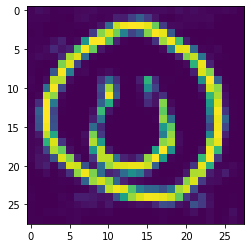

In [196]:
noise = np.random.normal(0, 1, (1, 100))
gen_imgs = generator.predict(noise)
plt.imshow(gen_imgs[0])